# Section 1: Model Functions

In [8]:
#Importing Functions

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
from sympy import symbols, solve
from time import process_time
import sys

In [9]:
### Functions - Income Distributions and Adjustments based on number of farm laborers/household migrants


#Function that calculates Weibull scale parameter from mean and shape parameter
def wei_scale(mean, shape):
    scale = (mean / math.gamma(1 + 1 / shape))
    
    return scale


#Function that calculates annual farm mean as a function of time, starting income and end income
def annual_mean_income(start_mean, end_mean, strategy, start_shape, end_shape, time, t):
    delta_mean = end_mean - start_mean
    delta_shape = end_shape - start_shape
    if t <= time:
        mean = start_mean + delta_mean * t / time
        shape = start_shape + delta_shape * t / time

    else:
        mean = end_mean
        shape = end_shape
        
    if (strategy == 'Overseas Migrate') or (strategy == 'Local Migrate'):
        mean_income = math.exp(mean + shape ** 2 / 2)
        std_dev = math.sqrt((math.exp(shape ** 2) - 1) * (math.exp(2 * mean + shape ** 2)))
        
    else:
        mean_income = mean * math.gamma(1 + 1 / shape)
        std_dev = math.sqrt(mean ** 2 * (math.gamma(1 + 2 / shape) - (math.gamma(1 + 1 / shape)) ** 2))

    return mean_income, std_dev


#Function that adjusts farm income based on labor available
def pi_farm(income, starting_size, household_size, hill_1):
    if household_size == starting_size:
        farm_income = income
    else:
        farm_income = income * (household_size) ** hill_1 / (1 + household_size ** hill_1)
    
    return farm_income

#Function that solves for base farm value (i.e. farm with all households present) based on observed farm income and number of laborers
def inverse_farm(farm_income, starting_size, migrants, hill_1):
    
    laborers = int(starting_size - migrants)
    if laborers == starting_size:
        adjustment_factor = 1
    else:
        adjustment_factor = laborers ** hill_1 / (1 + laborers ** hill_1)
    
    
    base_farm_income = farm_income / adjustment_factor
    
    
    return base_farm_income

#Function that calculates household remittances based on number of household migrants
def remit(overseas_migrants, local_migrants, overseas_migration_return, local_migration_return, hill_2):
    m = int(overseas_migrants)
    n = int(local_migrants)
    remittances = 0
    overseas_running_remit = 0
    local_running_remit = 0
    
    for i in range(m):
        overseas_running_remit += (overseas_migration_return * (1 - i ** hill_2 / (1 + i ** hill_2)))

    for j in range(n):
        local_running_remit += (local_migration_return * (1 - j ** hill_2 / (1 + j ** hill_2)))
        
    remittances = overseas_running_remit + local_running_remit

    return remittances, overseas_running_remit, local_running_remit


#Function that solves for base migration value based on household remittances and number of migrants
def inverse_remit(migrants, household_remittances, hill_2):
    m = int(migrants)
    
    adjustment_factor = 1
    if m > 1:
        for i in range(m-1):
            adjustment_factor += (1 - (i+1) ** hill_2 / (1 + (i+1) ** hill_2))
            
    base_remittance = household_remittances / adjustment_factor
            
    return base_remittance

#Function that calculates standard deviation of a truncated distribution, given income sample and expected income of entire distribution
def trunc_std(income_sample, mu):
    running_var = 0
    N = len(income_sample)
    for i in range(N):
        running_var += (income_sample[i] - mu) ** 2
    
    std = math.sqrt(running_var / (N-1))
    
    
    return std


In [10]:
#Functions - Setting up household social networks (for Layers 2-4) and assigning educational characteristics (Layers 3-4)

# Function that assigns each agent a number of social connections based on power law distribution
def number_connections(network_type, min_size, max_size, gamma, uniform_connections):
        if network_type == 'scale-free':
            j = int((((max_size) ** (gamma + 1) - min_size ** (gamma + 1)) * random.random() + min_size ** (gamma + 1)) ** (1 / (gamma + 1)))
        elif network_type == 'uniform':
            j = uniform_connections
        else:
            raise ValueError('Network Type improperly specified')
            
        return j

#Function that sets up social network
def social_network(households, connections):
    household_connections = {}
    for a in range(households):
        household_connections.update({a: connections[a]})
    sorted_households = sorted(household_connections, key=household_connections.__getitem__, reverse=True)

    network = nx.DiGraph()
    vertices = str(households)
    
    h = nx.path_graph(households)
    network.add_nodes_from(h)
    
    for n in range(households):
        house = sorted_households[n]

        edges = int(household_connections[house])
        count = 0
        #Choose random edges for each number of connection
        while count < edges:
            neighbor = int(random.random() * households)
            if network.in_degree(neighbor) >= connections[neighbor] or neighbor == house:
                count += 0
            else:
                network.add_edge(house, neighbor)
                count += 1
    return network

#Function that creates a distribution of education levels
def educate(households, edu_dict):
    education_level = [''] * households
    for a in range(households):
        if np.random.random() > (1 - educ_dict['tertiary'][0]):
            education_level[a] = 'Tertiary'
        elif np.random.random() > (1 - educ_dict['tertiary'][0] - educ_dict['secondary'][0]):
            education_level[a] = 'Secondary'
        else:
            education_level[a] = 'Primary'
    
    return education_level

#Function that assigns initial wealth based on education level
def educ_assign(households, education_level, edu_dict):
    init_savings = np.zeros(households)
    risk_aversion = np.zeros(households)
    objective_weight = np.zeros(households)
    attributes = []
    
    for a in range(households):
        if education_level[a] == 'Tertiary':
            init_savings[a] = np.random.exponential(scale=educ_dict['tertiary'][1])
            risk_aversion[a] = np.random.normal(educ_dict['tertiary'][2], educ_dict['tertiary'][3])
            objective_weight[a] = np.random.normal(educ_dict['tertiary'][4], educ_dict['tertiary'][5])

        elif education_level[a] == 'Secondary':
            init_savings[a] = np.random.exponential(scale=educ_dict['secondary'][1])
            risk_aversion[a] = np.random.normal(educ_dict['secondary'][2], educ_dict['secondary'][3])
            objective_weight[a] = np.random.normal(educ_dict['secondary'][4], educ_dict['secondary'][5])
            
        else:
            init_savings[a] = np.random.exponential(scale=educ_dict['primary'][1])
            risk_aversion[a] = np.random.normal(educ_dict['primary'][2], educ_dict['primary'][3])
            objective_weight[a] = np.random.normal(educ_dict['primary'][4], educ_dict['primary'][5])

            
        attributes.append([init_savings[a], risk_aversion[a], objective_weight[a]])
    
    return attributes


# Function that adjusts migration cost as a function of social networks
def migrate_cost_adjust(migration_cost, household_overseas_migrants, household_local_migrants, starting_size, household_network, total_pop, i): 
    network_pop = starting_size[i]
    network_overseas_migrants = household_overseas_migrants[i]
    network_local_migrants = household_local_migrants[i]
    
    for a in range(households):
        if a in household_network[i]:
            network_overseas_migrants += household_overseas_migrants[a]
            network_local_migrants += household_local_migrants[a]
            network_pop += starting_size[a]
        else:
            network_overseas_migrants += 0
            network_local_migrants += 0
            
    network_overseas_migrant_proportion = network_overseas_migrants / network_pop
    network_local_migrant_proportion = network_local_migrants / network_pop
    
    adjusted_overseas_cost = migration_cost['overseas'] * 1/ (math.exp(network_overseas_migrant_proportion))
    adjusted_local_cost = migration_cost['local'] * 1/ (math.exp(network_local_migrant_proportion))

    return adjusted_overseas_cost, adjusted_local_cost


In [11]:
#Functions - Creating climate effects, including adjusting crop yields, sampling droughts, creating separate income distributions for drought vs. non-drought years

#Function that determines overall crop yield due to climate effects in year t - Note: no longer adjusts for drought (this is done later)
#def climate_effects(start_temp, final_temp, time, mu, spei_temp_coef, sigma, bau_threshold, diverse_threshold, yield_coef, t, experiment_start, drought_cycles):
    #Calculating temperature increase and change in distribution of droughts due to warming
    #temp_increment = (final_temp - start_temp) / time
    #mu_t = mu + temp_increment * t * spei_temp_coef
    
    #Calling climate functions
    #bau_drought_status, diverse_drought_status = drought_sampling(mu_t, sigma, bau_threshold, diverse_threshold)
    
    #yield_shift = temp_crop_yield(temp_increment, yield_coef, time, t)
    
    #crop_adjustment_factor = -yield_shift #Indicates starting crop yield is reduced by a fraction equal to yield_shift

    #return crop_adjustment_factor, bau_drought_status, diverse_drought_status


#Function that determines overall crop yield due to climate effects in year t - Note: no longer adjusts for drought (this is done later)
def climate_effects(start_temp, final_temp, time, mu, spei_temp_coef, sigma, bau_threshold, diverse_threshold, yield_coef, t, experiment_start, drought_cycles):
    #Calculating temperature increase and change in distribution of droughts due to warming
    temp_increment = (final_temp - start_temp) / time
    mu_t = mu + temp_increment * t * spei_temp_coef
    
    #Adjusting drought status based on tau and experiment year
    if t < experiment_start:
        bau_drought_status, diverse_drought_status = drought_sampling(mu_t, sigma, bau_threshold, diverse_threshold)
    else:
        if t in drought_cycles:
            bau_drought_status = 1
            diverse_drought_status = 1
        else:
            bau_drought_status = 0
            diverse_drought_status = 0
    
    yield_shift = temp_crop_yield(temp_increment, yield_coef, time, t)
    
    crop_adjustment_factor = -yield_shift #Indicates starting crop yield is reduced by a fraction equal to yield_shift

    return crop_adjustment_factor, bau_drought_status, diverse_drought_status

#Function that adjusts farm productivity as a function of long-term temperature change
def temp_crop_yield(temp_increment, yield_coef, time, t):
    yield_shift = (temp_increment * yield_coef) * t #Percent decrease in crops from initial conditions due to long-temr effects
    return yield_shift

#Function that determines if a drought occurs in year t by sampling a distribution
def drought_sampling(mu, sigma, bau_threshold, diverse_threshold):
    random = np.random.normal(mu, sigma, 1)
    if random < bau_threshold:
        bau_drought = 1
    else:
        bau_drought = 0
    if random < diverse_threshold:
        diverse_drought = 1
    else:
        diverse_drought = 0
    
    return bau_drought, diverse_drought

#Function that calculates probability of drought in year t based on 1000 simulations of SPEI distribution
def drought_probability(start_temp, final_temp, time, t, spei_temp_coef, tau_b, tau_d):
    delta_t = (final_temp - start_temp) / time * t
    spei_mean = delta_t * spei_temp_coef
    samples = 1000
    spei_distr = np.zeros(samples)
    
    for step in range(samples):
        spei_distr[step] = norm.ppf((step / samples), loc=spei_mean)
    
    drought_bau = sum(p < tau_b for p in spei_distr)
    drought_diverse = sum(q < tau_d for q in spei_distr)
    
    p_bau = drought_bau / samples
    p_diverse = drought_diverse / samples
    
    probability = {'BAU': p_bau, 'Diverse': p_diverse}
    
    return probability

#Function that sets up a maximum income threshold to use for drought use
def drought_income_threshold(bau_scale, diverse_scale, bau_k, diverse_k, p_bau, p_diverse):
    bau_distribution = bau_scale * np.random.weibull(bau_k, size=1000)
    diverse_distribution = diverse_scale * np.random.weibull(diverse_k, size=1000)
    
    bau_threshold = np.percentile(bau_distribution, (100*p_bau))
    diverse_threshold = np.percentile(diverse_distribution, (100*p_diverse))
    
    return bau_threshold, diverse_threshold

#Function that sets up income distributions based on drought and non-drought conditions
def drought_income_distributions(bau_scale, bau_k, diverse_scale, diverse_k, bau_threshold, diverse_threshold):
    income_distribution = {'BAU':[], 'Diverse':[]}
    bau_distribution = bau_scale * np.random.weibull(bau_k, size=1000)
    diverse_distribution = diverse_scale * np.random.weibull(diverse_k, size=1000)
    
    #Sorting distributions in ascending order
    sorted_bau = list(np.sort(bau_distribution))
    sorted_diverse = list(np.sort(diverse_distribution))
    
    #Inserting the pre-determined threshold in sorted distributions and calculating how many values are below this threshold
    bisect.insort(sorted_bau, bau_threshold)
    bisect.insort(sorted_diverse, diverse_threshold)
    bau_index = sorted_bau.index(bau_threshold)
    diverse_index = sorted_diverse.index(diverse_threshold)
    
    #Creating split distributions
    bau_drought_income = sorted_bau[0:bau_index]
    bau_regular_income = sorted_bau[bau_index:1000]
    diverse_drought_income = sorted_diverse[0:diverse_index]
    diverse_regular_income = sorted_diverse[diverse_index:1000] 
    
    #Seeding drought distributions with 1 value if there are no values in current distribution
    if len(bau_drought_income) == 0:
        bau_drought_income = [0,0,0]
    if len(diverse_drought_income) == 0:
        diverse_drought_income = [0,0,0]
    
    income_distribution['BAU'] = (bau_drought_income, bau_regular_income)
    income_distribution['Diverse'] = (diverse_drought_income, diverse_regular_income)
    
    return income_distribution            


#Function that samples from different parts of income distribution based on drought conditions
def farm_income_sampling(bau_drought_income, bau_regular_income, diverse_drought_income, diverse_regular_income):  

    bau_drought_income = random.choice(bau_drought_income) 
    bau_regular_income = random.choice(bau_regular_income)
    
    diverse_drought_income = random.choice(diverse_drought_income)
    diverse_regular_income = random.choice(diverse_regular_income)
        
    return bau_drought_income, bau_regular_income, diverse_drought_income, diverse_regular_income

In [12]:
#Functions - Main household decision-making functions, including forming perceptions from social networks, weighting perceptions with objective information, sorting strategy options by utility, selecting strategy

#Function that allows an agent to search negibhors' networks for strategy information, if he/she has no immediate inforamtion
def information_search(strategy, households, household_network, perception, drought_perception, secondary_effects, secondary_network, i):
    #Add loops that iterate over already-defined household networks (too long to do for loops)
    
    missing_strategy = str(strategy)
    instruction = 'Search'
    count = 0
    perceived_pi = 0
    perceived_var = 0
    perceived_drought = 0

    #Checking if a first-degree neighbor has a non-zero perception of the strategy
    for house in household_network[i]:
        a = int(house)
        if instruction == 'Search':
            payoff_perception = perception[a][missing_strategy][0]
        
            if payoff_perception == 0 or payoff_perception == 'nan':
                instruction = 'Search'
            else:
                instruction = 'Stop'
                perceived_pi = payoff_perception
                perceived_var = perception[a][missing_strategy][1]
                
                if (missing_strategy != 'Overseas Migrate') and (missing_strategy != 'Local Migrate'):
                    perceived_drought = drought_perception[a][missing_strategy]
                                              
    #Checking if a second-degree neighbor has a non-zero perception of the strategy
    if instruction == 'Search' and secondary_effects == 'on':
        for house in secondary_network:
            b = int(house)
            if instruction == 'Search':
                payoff_perception = perception[b][missing_strategy][0]
                if payoff_perception == 0 or payoff_perception == 'nan':
                    instruction == 'Search'
                else:
                    instruction == 'Stop'
                    perceived_pi = payoff_perception
                    perceived_var = perception[b][missing_strategy][1]
                    if (missing_strategy != 'Overseas Migrate') and (missing_strategy != 'Local Migrate'):
                        perceived_drought = drought_perception[b][missing_strategy]
                                              
    #If both loops above fail, sampling population at random until we find a non-zero strategy
    while (instruction == 'Search') & (count < 100):
        count += 1
        household = np.random.randint(0, households)
        payoff_perception = perception[household][missing_strategy][0]
            
        if payoff_perception == 0 or payoff_perception == 'nan':
            instruction = 'Search'
        else:
            instruction = 'Stop'
            perceived_pi = payoff_perception
            perceived_var = perception[household][missing_strategy][1]
            if (missing_strategy != 'Overseas Migrate') and (missing_strategy != 'Local Migrate'):
                perceived_drought = drought_perception[household][missing_strategy]
    

    return perceived_pi, perceived_var, perceived_drought


#Function to create an initial distribution of perceived strategy mean income and standard deviation for each household
def perception_init(memory, p_drought_bau, bau_scale, planner_bau_income, bau_regular_avg_income, bau_k, bau_regular_std, p_drought_diverse, diverse_scale, planner_diverse_income, diverse_regular_avg_income, diverse_k, diverse_regular_std, migrate_mean_income, migrate_k):
    perceived_init = {'BAU':[0], 'BAU_Insurance':[0], 'Diverse':[0], 'Diverse_Insurance':[0], 'Overseas Migrate':[0], 'Local Migrate':[0]}
    
    #Re-calculating k parameter of Weibull distributions for insurance options, given different std deviations and mean
    
    bau_insurance_mean = p_drought_bau * planner_bau_income + (1 - p_drought_bau) * bau_regular_avg_income
    diverse_insurance_mean = p_drought_diverse * planner_diverse_income + (1 - p_drought_diverse) * diverse_regular_avg_income    
    bau_insurance_k = (bau_regular_std / bau_insurance_mean) ** -1.086
    diverse_insurance_k = (diverse_regular_std / diverse_insurance_mean) ** -1.086
    
    bau_insurance_scale = wei_scale(bau_insurance_mean, bau_insurance_k)
    diverse_insurance_scale = wei_scale(diverse_insurance_mean, diverse_insurance_k)
    
    
    bau_distribution = bau_scale * np.random.weibull(bau_k, memory)
    bau_insurance_distribution = bau_insurance_scale * np.random.weibull(bau_insurance_k, memory)
    diverse_distribution = diverse_scale * np.random.weibull(diverse_k, memory)
    diverse_insurance_distribution = diverse_insurance_scale * np.random.weibull(diverse_insurance_k, memory) #need to update k factors for insurance distributions
    overseas_migrate_distribution = np.random.lognormal(migrate_start_income['overseas'], migrate_k['overseas'], memory)
    local_migrate_distribution = np.random.lognormal(migrate_start_income['local'], migrate_k['local'], memory)
    
    perceived_init['BAU'] = bau_distribution
    perceived_init['BAU_Insurance'] = bau_insurance_distribution
    perceived_init['Diverse'] = diverse_distribution
    perceived_init['Diverse_Insurance'] = diverse_insurance_distribution
    perceived_init['Overseas Migrate'] = overseas_migrate_distribution
    perceived_init['Local Migrate'] = local_migrate_distribution
    
    return perceived_init    


#Function that calculates perceived payoffs of strategies based on network information
def perceived_pi(secondary_effects, perception_init, memory, starting_size, household_size, household_network, perception, drought_perception, household_savings, farm_strategy, household_remittances, remittances_received, remittances_shared, household_income, bau_cost, diverse_cost, migrate_cost, bau_drought_threshold, diverse_drought_threshold, bau_prem, diverse_prem, remittance_beta, cash_transfer, subsidies, household_overseas_migrants, household_local_migrants, overseas_trip_status, local_trip_status, bau_scale, diverse_scale, bau_start_k, diverse_start_k, migrate_start_income, migrate_k, theta, t, i):
    perceived_pi = {'BAU':0, 'BAU_Insurance':0, 'Diverse':0, 'Diverse_Insurance':0, 'Overseas Migrate':0, 'Local Migrate':0}
    
    init_bau_drought = 0
    init_diverse_drought = 0
    
    
    #Keeps running list of payoffs for each strategy among network (these are separated from own payoffs in case we want to weight those differently in the future)
    neighbor_count = 0 #Counts direct neighbors of household i
    network_bau_payoffs = []
    network_bau_insurance_payoffs = []
    network_bau_count = 0
    network_bau_insurance_count = 0
    network_bau_drought = 0
    
    network_diverse_payoffs = []
    network_diverse_insurance_payoffs = []
    network_diverse_count = 0
    network_diverse_insurance_count = 0
    network_diverse_drought = 0
    
    network_overseas_migrate_payoffs = []
    network_overseas_migrate_count = 0
    network_local_migrate_payoffs = []
    network_local_migrate_count = 0
    
    neighbor_network = [] #List that will contain neighbors of household i's neighbors
    already_counted = [] #Creates list that stores numbers of households already counted (to prevent double-counting)
    secondary_count = 0 #Counts neighbors of household i's neighbors (that aren't themselves direct neighbors of i)
    secondary_bau_payoffs = []
    secondary_bau_insurance_payoffs = []
    secondary_bau_count = 0
    secondary_bau_insurance_count = 0
    secondary_bau_drought = 0
    
    secondary_diverse_payoffs = []
    secondary_diverse_insurance_payoffs = []
    secondary_diverse_count = 0
    secondary_diverse_insurance_count = 0
    secondary_diverse_drought = 0
    
    secondary_overseas_migrate_payoffs = []
    secondary_overseas_migrate_count = 0
    secondary_local_migrate_payoffs = []
    secondary_local_migrate_count = 0
    
    #Creating time frame from (t-memory, t), unless t < memory, in which case give agents init observations
    starter_perceptions = len(perception_init['BAU'])
    if t < starter_perceptions:
        start = 0
        init_observations = starter_perceptions - t
        bau_init_observations = perception_init['BAU'][-init_observations:]
        bau_insurance_init_observations = perception_init['BAU_Insurance'][-init_observations:]
        diverse_init_observations = perception_init['Diverse'][-init_observations:]
        diverse_insurance_init_observations = perception_init['Diverse_Insurance'][-init_observations:]
        overseas_migrate_init_observations = perception_init['Overseas Migrate'][-init_observations:]
        local_migrate_init_observations = perception_init['Local Migrate'][-init_observations:]
        
        for e in range(init_observations):
            if bau_init_observations[e] < bau_drought_threshold:
                init_bau_drought += 1
            if diverse_init_observations[e] < diverse_drought_threshold:
                init_diverse_drought += 1
    else:
        start = max((t - memory),0)
        init_observations = 0
        bau_init_observations = []
        bau_insurance_init_observations = []
        diverse_init_observations = []
        diverse_insurance_init_observations = []
        overseas_migrate_init_observations = []
        local_migrate_init_observations = []
        
    #Loop for first-degree neighbors
    
    for a in range(households):
        
        if a in household_network[i]:
            neighbor_network.append(household_network[a])
            neighbor_count += 1
            already_counted.append(a)
            
            for b in range(start, t):
                strategy = farm_strategy[b][a]
                
                if overseas_trip_status[b,a] == 1:
                    migrate_expense = migrate_cost[b,a,0]
                    overseas_migrants = household_overseas_migrants[b,a] - 1 #i.e. revenue earning overseas migrants
                    local_migrants = household_local_migrants[b,a]
                
                elif local_trip_status[b,a] == 1:
                    migrate_expense = migrate_cost[b,a,1]
                    overseas_migrants = household_overseas_migrants[b,a]
                    local_migrants = household_local_migrants[b,a] #Because local migrants can earn income in first time step
                    
                else:
                    migrate_expense = 0
                    overseas_migrants = household_overseas_migrants[b,a]
                    local_migrants = household_local_migrants[b,a]
                
                #Normalizes observed remittances (overseas and local) to a single "base" migrant
                if overseas_migrants > 0:
                    network_overseas_migrate_count += 1
                    observed_overseas_remittances = household_remittances[b,a,1]
                    observed_income = inverse_remit(overseas_migrants, observed_overseas_remittances, hill_2)
                    network_overseas_migrate_payoffs.append(observed_income)

                if local_migrants > 0:
                    network_local_migrate_count += 1
                    observed_local_remittances = household_remittances[b,a,2]
                    observed_income = inverse_remit(local_migrants, observed_local_remittances, hill_2)
                    network_local_migrate_payoffs.append(observed_income)
                
                total_household_migrants = household_local_migrants[b,a] + household_overseas_migrants[b,a]
                
                #Normalizes observed farm income to a full household                
                if strategy == 'BAU':
                    total_farm_income = (household_income[b,a] + bau_cost + migrate_expense - household_remittances[b,a,0] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], total_household_migrants, hill_1) #this takes household_migrants instead of migrants becasue migrants who leave in that time step don't contribute to farm income
                    network_bau_count += 1
                    network_bau_payoffs.append(observed_farm_income)
                    if observed_farm_income <= bau_drought_threshold:
                        network_bau_drought += 1
                                            
                elif strategy == 'BAU_Insurance':
                    total_farm_income = (household_income[b,a] + bau_cost + bau_prem[b] + migrate_expense - household_remittances[b,a,0] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], total_household_migrants, hill_1)
                    network_bau_insurance_count += 1
                    network_bau_insurance_payoffs.append(observed_farm_income)
                    #if observed_farm_income <= bau_drought_threshold:
                        #network_bau_drought += 1
                    
                elif strategy == 'Diverse_Insurance':
                    total_farm_income = (household_income[b,a] + diverse_cost + diverse_prem[b] + migrate_expense - household_remittances[b,a,0] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], total_household_migrants, hill_1)
                    network_diverse_insurance_count += 1
                    network_diverse_insurance_payoffs.append(observed_farm_income)
                    #if observed_farm_income <= diverse_drought_threshold:
                        #network_diverse_drought += 1
                    
                elif strategy == 'Diverse':
                    total_farm_income = (household_income[b,a] + diverse_cost + migrate_expense - household_remittances[b,a,0] - remittances_received[b,a] + remittances_shared[b,a] - cash_transfer)
                    observed_farm_income = inverse_farm(total_farm_income, starting_size[a], total_household_migrants, hill_1)
                    network_diverse_count += 1
                    network_diverse_payoffs.append(observed_farm_income)
                    if observed_farm_income <= diverse_drought_threshold:
                        network_diverse_drought += 1

    #Loop for second-degree neighbors
    if secondary_effects == 'off':
        secondary_network = ['']
        
    else:
        for neighbor in range(neighbor_count):
            secondary_network = neighbor_network[neighbor] #List of neighbors of one of household i's neighbors
            
            for d in range(households):
                
                if (d in secondary_network) and (d not in already_counted): #Ensures that we are not double-counting i's direct neighbors or previously counted secondary neighbors
                    secondary_count += 1
                    already_counted.append(d)

                    for year in range(start, t-1):
                        secondary_strategy = farm_strategy[year][d]
                        
                        if overseas_trip_status[year,d] == 1:
                            migrate_expense = migrate_cost[year,d,0]
                            secondary_overseas_migrants = household_overseas_migrants[year,d] - 1 #i.e. revenue earning overseas migrants
                            secondary_local_migrants = household_local_migrants[year,d]
                            
                        elif local_trip_status[year,d] == 1:
                            migrate_expense = migrate_cost[year,d,1]
                            secondary_overseas_migrants = household_overseas_migrants[year,d]
                            secondary_local_migrants = household_local_migrants[year,d] #Local migrants can still earn income in first timestep

                        else:
                            migrate_expense = 0
                            secondary_overseas_migrants = household_migrants[year,d]
                            secondary_local_migrants = household_migrants[year,d]
                       
                        #Normalizing remittances to 1 base migrant
                        if secondary_overseas_migrants > 0:
                            secondary_overseas_migrate_count += 1
                            observed_overseas_remittances = household_remittances[year,d,1]
                            observed_income = inverse_remit(overseas_migrants, observed_overseas_remittances, hill_2)
                            secondary_overseas_migrate_payoffs.append(observed_income)
                            
                        if secondary_local_migrants > 0:
                            secondary_local_migrate_count += 1
                            observed_local_remittances = household_remittances[year,d,2]
                            observed_income = inverse_remit(local_migrants, observed_local_remittances, hill_2)
                            secondary_local_migrate_payoffs.append(observed_income)
                        
                        total_household_migrants = household_local_migrants[year,d] + household_overseas_migrants[year,d]
    
                        if secondary_strategy == 'BAU':
                            total_farm_income = (household_income[year,d] + bau_cost + migrate_expense - household_remittances[year,d,0] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], total_household_migrants, hill_1)
                            secondary_bau_count += 1
                            secondary_bau_payoffs.append(observed_farm_income)
                            if observed_farm_income <= bau_drought_threshold:
                                secondary_bau_drought += 1
                                
                        elif secondary_strategy == 'BAU_Insurance':
                            total_farm_income = (household_income[year,d] + bau_cost + bau_prem[year] + migrate_expense - household_remittances[year,d,0] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], total_household_migrants, hill_1)
                            secondary_bau_insurance_count += 1
                            secondary_bau_insurance_payoffs.append(observed_farm_income)
                            #if observed_farm_income <= bau_drought_threshold:
                                #secondary_bau_drought += 1

                        elif secondary_strategy == 'Diverse':
                            total_farm_income = (household_income[year,d] + diverse_cost + migrate_expense - household_remittances[year,d,0] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], total_household_migrants, hill_1)
                            secondary_diverse_count += 1
                            secondary_diverse_payoffs.append(observed_farm_income)
                            if observed_farm_income <= diverse_drought_threshold:
                                secondary_diverse_drought += 1
                                
                        elif secondary_strategy == 'Diverse_Insurance':
                            total_farm_income = (household_income[year,d] + diverse_cost + diverse_prem[year] + migrate_expense - household_remittances[year,d,0] - remittances_received[year,d] + remittances_shared[year,d] - cash_transfer) 
                            observed_farm_income = inverse_farm(total_farm_income, starting_size[d], total_household_migrants, hill_1)
                            secondary_diverse_insurance_count += 1
                            secondary_diverse_insurance_payoffs.append(observed_farm_income)
                            #if observed_farm_income <= diverse_drought_threshold:
                                #secondary_diverse_drought += 1

    #Calculating average payoffs of each strategy for the household itself
    self_bau_payoffs = []
    self_bau_count = 0
    self_bau_drought = 0
    
    self_bau_insurance_payoffs = []
    self_bau_insurance_count = 0
    
    self_diverse_payoffs = []
    self_diverse_count = 0
    self_diverse_drought = 0
    
    self_diverse_insurance_payoffs = []
    self_diverse_insurance_count = 0
    
    self_overseas_migrate_payoffs = []
    self_local_migrate_payoffs = []
    self_overseas_migrate_count = 0
    self_local_migrate_count = 0
    
    for e in range(start, t):
        year_strategy = farm_strategy[e]
        strategy = year_strategy[i]


        if overseas_trip_status[e,i] == 1:
            migrate_expense = migrate_cost[e,i,0]
            self_overseas_migrants = household_overseas_migrants[e,i] - 1 #i.e. revenue earning overseas migrants
            self_local_migrants = household_local_migrants[e,i]
                            
        elif local_trip_status[e,i] == 1:
            migrate_expense = migrate_cost[e,i,1]
            self_overseas_migrants = household_overseas_migrants[e,i]
            self_local_migrants = household_local_migrants[e,i] #Local migrants can still earn income in first timestep

        else:
            migrate_expense = 0
            self_overseas_migrants = household_overseas_migrants[e,i]
            self_local_migrants = household_local_migrants[e,i]
            
        #Normalizing remittances to 1 base migrant
        if self_overseas_migrants > 0:
            self_overseas_migrate_count += 1
            observed_overseas_remittances = household_remittances[e,i,1]
            observed_income = inverse_remit(overseas_migrants, observed_overseas_remittances, hill_2)
            self_overseas_migrate_payoffs.append(observed_income)
                            
        if self_local_migrants > 0:
            self_local_migrate_count += 1
            observed_local_remittances = household_remittances[e,i,2]
            observed_income = inverse_remit(local_migrants, observed_local_remittances, hill_2)
            self_local_migrate_payoffs.append(observed_income)                        
        
        total_household_migrants = household_local_migrants[e,i] + household_overseas_migrants[e,i]

        if strategy == 'BAU':
            total_farm_income = (household_income[e,i] + bau_cost + migrate_expense - household_remittances[e,i,0] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer) 
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], total_household_migrants, hill_1)
            self_bau_count += 1
            self_bau_payoffs.append(observed_farm_income)
            if observed_farm_income <= bau_drought_threshold:
                self_bau_drought += 1
        
        elif strategy == 'BAU_Insurance':
            total_farm_income = (household_income[e,i] + bau_cost + bau_prem[e] + migrate_expense - household_remittances[e,i,0] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer) 
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], total_household_migrants, hill_1)
            self_bau_insurance_count += 1
            self_bau_insurance_payoffs.append(observed_farm_income)
            #if observed_farm_income <= bau_drought_threshold:
                #self_bau_drought += 1
                    
        elif strategy == 'Diverse':
            total_farm_income = (household_income[e,i] + diverse_cost + migrate_expense - household_remittances[e,i,0] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer)
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], total_household_migrants, hill_1)
            self_diverse_count += 1
            self_diverse_payoffs.append(observed_farm_income)
            if observed_farm_income <= diverse_drought_threshold:
                self_diverse_drought += 1
                
        elif strategy == 'Diverse_Insurance':
            total_farm_income = (household_income[e,i] + diverse_cost + diverse_prem[e] + migrate_expense - household_remittances[e,i,0] - remittances_received[e,i] + remittances_shared[e,i] - cash_transfer) 
            observed_farm_income = inverse_farm(total_farm_income, starting_size[i], total_household_migrants, hill_1)
            self_diverse_insurance_count += 1
            self_diverse_insurance_payoffs.append(observed_farm_income)
            #if observed_farm_income <= diverse_drought_threshold:
                #self_diverse_drought += 1
    
    #Calculate expectation and variance of utilities from own memories and network, weighting each observation equally
    if (init_observations + self_bau_count + network_bau_count + secondary_bau_count) == 0:
        household_info = information_search('BAU', households, household_network, perception, drought_perception, secondary_effects, secondary_network, i)
        perceived_bau_avg = household_info[0]
        perceived_bau_var = household_info[1]
        perceived_drought_bau = household_info[2]
        
    else:
        combined_bau = np.concatenate((bau_init_observations, self_bau_payoffs, network_bau_payoffs, secondary_bau_payoffs))
        perceived_bau_avg = np.average(combined_bau)
        perceived_bau_var = np.std(combined_bau)
        perceived_drought_bau = (init_bau_drought + self_bau_drought + network_bau_drought + secondary_bau_drought) / (init_observations + self_bau_count + network_bau_count + secondary_bau_count)
        
    if (init_observations + self_bau_insurance_count + network_bau_insurance_count + secondary_bau_insurance_count) == 0:
        household_info = information_search('BAU_Insurance', households, household_network, perception, drought_perception, secondary_effects, secondary_network, i)
        perceived_bau_insurance_avg = household_info[0]
        perceived_bau_insurance_var = (1 - perceived_drought_bau) * household_info[1]
        
    else:
        combined_bau_insurance = np.concatenate((bau_insurance_init_observations, self_bau_insurance_payoffs, network_bau_insurance_payoffs, secondary_bau_insurance_payoffs))
        perceived_bau_insurance_avg = np.average(combined_bau_insurance)
        perceived_bau_insurance_var = (1 - perceived_drought_bau) * np.std(combined_bau_insurance)
    
    
    if (init_observations + self_diverse_count + network_diverse_count + secondary_diverse_count) == 0:
        household_info = information_search('Diverse', households, household_network, perception, drought_perception, secondary_effects, secondary_network, i)
        perceived_diverse_avg = household_info[0]
        perceived_diverse_var = household_info[1]
        perceived_drought_diverse = household_info[2]

    else:
        combined_diverse = np.concatenate((diverse_init_observations, self_diverse_payoffs, network_diverse_payoffs, secondary_diverse_payoffs))
        perceived_diverse_avg = np.average(combined_diverse)
        perceived_diverse_var = np.std(combined_diverse)
        perceived_drought_diverse = (init_diverse_drought + self_diverse_drought + network_diverse_drought + secondary_diverse_drought) / (init_observations + self_diverse_count + network_diverse_count + secondary_diverse_count)
        
            
    if (init_observations + self_diverse_insurance_count + network_diverse_insurance_count + secondary_diverse_insurance_count) == 0:
        household_info = information_search('Diverse_Insurance', households, household_network, perception, drought_perception, secondary_effects, secondary_network, i)
        perceived_diverse_insurance_avg = household_info[0]
        perceived_diverse_insurance_var = (1 - perceived_drought_diverse) * household_info[1]
        
    else:
        combined_diverse_insurance = np.concatenate((diverse_insurance_init_observations, self_diverse_insurance_payoffs, network_diverse_insurance_payoffs, secondary_diverse_insurance_payoffs))
        perceived_diverse_insurance_avg = np.average(combined_diverse_insurance)
        perceived_diverse_insurance_var = (1 - perceived_drought_diverse) * np.std(combined_diverse_insurance)
                    
    if (init_observations + self_overseas_migrate_count + network_overseas_migrate_count + secondary_overseas_migrate_count) == 0:
        household_info = information_search('Overseas Migrate', households, household_network, perception, drought_perception, secondary_effects, secondary_network, i)
        perceived_overseas_migrate_avg = household_info[0]
        #perceived_migrate_var = (1 - remittance_beta) * household_info[1]
        perceived_overseas_migrate_var = household_info[1]
    else:
        combined_overseas_migrate = np.concatenate((overseas_migrate_init_observations, self_overseas_migrate_payoffs, network_overseas_migrate_payoffs, secondary_overseas_migrate_payoffs))
        perceived_overseas_migrate_avg = np.average(combined_overseas_migrate)
        #perceived_migrate_var = (1 - remittance_beta) * np.std(combined_migrate)
        perceived_overseas_migrate_var = np.std(combined_overseas_migrate)

    if (init_observations + self_local_migrate_count + network_local_migrate_count + secondary_local_migrate_count) == 0:
        household_info = information_search('Local Migrate', households, household_network, perception, drought_perception, secondary_effects, secondary_network, i)
        perceived_local_migrate_avg = household_info[0]
        #perceived_migrate_var = (1 - remittance_beta) * household_info[1]
        perceived_local_migrate_var = household_info[1]
    else:
        combined_local_migrate = np.concatenate((local_migrate_init_observations, self_local_migrate_payoffs, network_local_migrate_payoffs, secondary_local_migrate_payoffs))
        perceived_local_migrate_avg = np.average(combined_local_migrate)
        #perceived_migrate_var = (1 - remittance_beta) * np.std(combined_migrate)
        perceived_local_migrate_var = np.std(combined_local_migrate)
        
        
    #De-bugging code as diverse sometimes comes out with 'nan' for variance or mean
    
    if math.isnan(perceived_diverse_avg) == True:
        print('Self payoffs:', self_diverse_payoffs)
        print('First Network payoffs:', network_diverse_payoffs)
        print('Second Network payoffs;', secondary_diverse_payoffs)
        raise ValueError('For year:', t, 'household:', i, 'Diverse strategy mean perception has an issue')

        
    if math.isnan(perceived_diverse_var) == True:
        print('Self payoffs:', self_diverse_payoffs)
        print('First Network payoffs:', network_diverse_payoffs)
        print('Second Network payoffs;', secondary_diverse_payoffs) 
        raise ValueError('For year:', t, 'household:', i, 'Diverse strategy variance perception has an issue')
   
        
        
    perceived_pi = {'BAU': [perceived_bau_avg, perceived_bau_var], 'BAU_Insurance': [perceived_bau_insurance_avg, perceived_bau_insurance_var], 'Diverse': [perceived_diverse_avg, perceived_diverse_var], 'Diverse_Insurance':[perceived_diverse_insurance_avg, perceived_diverse_insurance_var], 'Overseas Migrate': [perceived_overseas_migrate_avg, perceived_overseas_migrate_var], 'Local Migrate': [perceived_local_migrate_avg, perceived_local_migrate_var]}    
    perceived_drought = {'BAU': perceived_drought_bau, 'BAU_Insurance': perceived_drought_bau, 'Diverse': perceived_drought_diverse, 'Diverse_Insurance': perceived_drought_diverse}
    
    return perceived_pi, perceived_drought



#Function that weighs perceived income and objective income sources
def weighted_pi(objective_weight, social_perception, social_drought, household_savings, planner_bau_income, bau_regular_avg_income, planner_diverse_income, diverse_regular_avg_income, migrate_mean_income, planner_bau_std, bau_regular_std, planner_diverse_std, diverse_regular_std, migrate_std, p_drought_bau, p_drought_diverse, remittance_beta, theta, t, horizon):
    weighted_income = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Overseas Migrate':[], 'Local Migrate':[]}
    weighted_std = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Overseas Migrate':[], 'Local Migrate':[]}
    weighted_drought = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Overseas Migrate':[], 'Local Migrate':[]}
    
    end = t + horizon
    
    perceived_payoff = social_perception
    perceived_drought = social_drought
    perceived_drought['Overseas Migrate'] = 0
    perceived_drought['Local Migrate'] = 0
    
    #objective_payoff = {'BAU':bau_mean_income[t:end] , 'BAU Insurance':bau_regular_avg_income, 'Diverse':diverse_mean_income[t:end], 'Diverse Insurance':diverse_regular_avg_income, 'Migrate':migrate_mean_income[t:end]}
    
    objective_payoff = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Overseas Migrate':[], 'Local Migrate':[]}
    objective_std = {'BAU':[], 'BAU_Insurance':[], 'Diverse':[], 'Diverse_Insurance':[], 'Overseas Migrate':[], 'Local Migrate':[]}
    objective_drought = {'BAU':p_drought_bau[t:end], 'BAU_Insurance':p_drought_bau[t:end], 'Diverse':p_drought_diverse[t:end], 'Diverse_Insurance': p_drought_diverse[t:end], 'Overseas Migrate':np.zeros(horizon), 'Local Migrate':np.zeros(horizon)}
    
    for a in range(horizon):   
        objective_payoff['BAU'].append(planner_bau_income[t+a])
        objective_std['BAU'].append(planner_bau_std[t+a])
        
        objective_payoff['BAU_Insurance'].append(p_drought_bau[t+a] * planner_bau_income[t+a] + (1 - p_drought_bau[t+a]) * bau_regular_avg_income[t+a])
        objective_std['BAU_Insurance'].append((1 - p_drought_bau[t+a]) * bau_regular_std[t+a])
        
        objective_payoff['Diverse'].append(planner_diverse_income[t+a])
        objective_std['Diverse'].append(planner_diverse_std[t+a])
        
        objective_payoff['Diverse_Insurance'].append(p_drought_diverse[t+a] * planner_diverse_income[t+a] + (1 - p_drought_diverse[t+a]) * diverse_regular_avg_income[t+a])
        objective_std['Diverse_Insurance'].append((1 - p_drought_diverse[t+a]) * diverse_regular_std[t+a])
        
        objective_payoff['Overseas Migrate'].append(migrate_mean_income['overseas'][t+a])
        objective_std['Overseas Migrate'].append((1 - remittance_beta) * migrate_std['overseas'][t+a])
    
        objective_payoff['Local Migrate'].append(migrate_mean_income['local'][t+a])
        objective_std['Local Migrate'].append((1 - remittance_beta) * migrate_std['local'][t+a])
        
    for key in ['BAU', 'BAU_Insurance', 'Diverse', 'Diverse_Insurance', 'Overseas Migrate', 'Local Migrate']:
        for a in range(horizon): 
            weighted_income[key].append(objective_weight * objective_payoff[key][a] + (1 - objective_weight) * perceived_payoff[key][0])
            weighted_std[key].append(objective_weight * objective_std[key][a] + (1 - objective_weight) * perceived_payoff[key][1])
            weighted_drought[key].append(objective_weight * objective_drought[key][a] + (1 - objective_weight) * perceived_drought[key])
    
    
    return weighted_income, weighted_std, weighted_drought

#Function that calculates negative utility of perceived risk associated with each livelihood strategy
def markowitz(expected_income, variance, vol_weight, household_savings, theta):
    
    mark_adjusted = expected_income - vol_weight * variance
    #mark_utility = utility(mark_adjusted, household_savings, theta) #Note - if this is commented out, utility is calculated without household savings as a reference
    
    return mark_adjusted

#New Function to calculate incremental utility of an expected income as a function of reference point and risk aversion
def utility(income, reference, theta):
    if theta == 1:
        if (income + reference) > 0:
            new_utils = np.log(income + reference)
        elif (income + reference) == 0:
            new_utils = 0
        else:
            new_utils = -np.log(-(income + reference))
        
        if reference > 0:
            old_utils = np.log(reference)
        elif reference == 0:
            old_utils = 0
        else:
            old_utils = -np.log(-reference)
        
    else:
        if (income + reference) >= 0:
            new_utils = ((income + reference) ** (1 - theta) - 1) / (1 - theta)
        else:
            new_utils = (-(-(income + reference)) ** (1 - theta) - 1) / (1 - theta)
        
        if reference >= 0:
            old_utils = (reference ** (1 - theta) - 1) / (1 - theta)
        else:
            old_utils = (-(-reference) ** (1 - theta) - 1) / (1 - theta)
        
    
    incremental_utils = new_utils - old_utils
    
    return new_utils



# Function that calculates adaptation strategy payoffs over next 'horizon' years as perceived by farmer in year t
def calc_pi(status, weighted_income, weighted_var, weighted_drought, household_savings, migrate_mean_income, remittance_beta, remittance_bank_take, overseas_migrants, local_migrants, migration_cost, hill_1, diverse_mean_income, diverse_regular_mean_income, diverse_cost, diverse_prem, bau_mean_income, bau_regular_mean_income, bau_cost, bau_prem, starting_size, household_size, farm_strategy, delta, theta, vol_weight, cash_transfer, subsidies, t, horizon):
    pi = {}
    
    income_bau = np.zeros(horizon)
    std_bau = np.zeros(horizon)
    
    income_bau_insurance = np.zeros(horizon)
    std_bau_insurance = np.zeros(horizon)
    
    income_cropdiverse = np.zeros(horizon)
    std_cropdiverse = np.zeros(horizon)
    
    income_cropdiverse_insurance = np.zeros(horizon)
    std_cropdiverse_insurance = np.zeros(horizon)
    
    income_overseas_migrate = np.zeros(horizon)
    income_local_migrate = np.zeros(horizon)
    std_overseas_migrate = np.zeros(horizon)
    std_local_migrate = np.zeros(horizon)
    pi_status_quo = np.zeros(horizon)
    
    pi_overseas_migrate = np.zeros(horizon)
    pi_local_migrate = np.zeros(horizon)
    pi_cropdiverse = np.zeros(horizon)
    pi_cropdiverse_insurance = np.zeros(horizon)
    pi_bau = np.zeros(horizon)
    pi_bau_insurance = np.zeros(horizon)

    #Checks if there are already migrants that can return back, starting with local migrants and then overseas migrants.
    if local_migrants[t-1] > 0:
        farm_potential_labor = household_size + 1
        farm_local_potential_migrants = local_migrants[t-1] - 1
        farm_overseas_potential_migrants = overseas_migrants[t-1]
        
    elif overseas_migrants[t-1] > 0:
        farm_potential_labor = household_size + 1
        farm_local_potential_migrants = local_migrants[t-1]
        farm_overseas_potential_migrants = overseas_migrants[t-1] - 1
        
    else:
        farm_potential_labor = household_size
        farm_local_potential_migrants = local_migrants[t-1]
        farm_overseas_potential_migrants = overseas_migrants[t-1]
    
    #Checks if there are household members who could migrate
    if household_size > 0:
        migrate_overseas_potential_migrants = overseas_migrants[t-1] + 1
        migrate_local_potential_migrants = local_migrants[t-1] + 1
        migrate_potential_labor = household_size - 1
    else:
        migrate_overseas_potential_migrants = overseas_migrants[t-1]
        migrate_local_potential_migrants = local_migrants[t-1]
        migrate_potential_labor = household_size
    
    for n in range(0, horizon):
        #Creating dummy farm variables for tracking residual farm income for Migrate strategy
        if farm_strategy == 'BAU':
            farm_cost = bau_cost
            farm_income = bau_mean_income[t+n]
            perceived_income = weighted_income['BAU'][n]
        
        elif farm_strategy == 'BAU_Insurance':
            farm_cost = bau_cost + bau_prem
            farm_income = bau_mean_income[t+n]
            perceived_income = weighted_income['BAU_Insurance'][n]

        elif farm_strategy == 'Diverse_Insurance':
            farm_cost = diverse_cost + diverse_prem
            farm_income = diverse_mean_income[t+n]
            perceived_income = weighted_income['Diverse_Insurance'][n]
        
        elif farm_strategy == 'Diverse':           
            farm_cost = diverse_cost
            farm_income = diverse_mean_income[t+n]
            perceived_income = weighted_income['Diverse'][n]
        
        else:
            farm_cost = 0
            farm_income = 0
            perceived_income = 0
            
        if status == 'rational':
            pi_status_quo[n] = cash_transfer + pi_farm(farm_income, starting_size, household_size, hill_1) - farm_cost + remit(overseas_migrants[t-1], local_migrants[t-1], migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0]
            pi_cropdiverse[n] = cash_transfer + pi_farm(diverse_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - diverse_cost + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0]
            pi_cropdiverse_insurance[n] = cash_transfer + pi_farm(diverse_regular_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - (diverse_cost + diverse_prem) + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0]
            pi_bau[n] = cash_transfer + pi_farm(bau_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - bau_cost + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0]
            pi_bau_insurance[n] = cash_transfer + pi_farm(bau_regular_mean_income[t+n], starting_size, farm_potential_labor, hill_1) - (bau_cost + bau_prem) + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0]
            
            if household_size == 0:
                pi_overseas_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], local_migrants[t-1], migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0] #Indicates continuation of all household members migrating
                pi_local_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], local_migrants[t-1], migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0] #Indicates continuation of all household members migrating

            elif household_size == 1:
                if n == 0:
                    pi_overseas_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], local_migrants[t-1], migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0] - migration_cost[0] #Accounting for initial up-front cost
                    pi_local_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], migrate_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0] - migration_cost[1] #Accounting for initial up-front cost, but possibility of earning local remittances right away

                else:
                    pi_overseas_migrate[n] = cash_transfer + remit(migrate_overseas_potential_migrants, local_migrants[t-1], migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0]
                    pi_local_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], migrate_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0]
                
            else:
                if n == 0:
                    pi_overseas_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], local_migrants[t-1], migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost - migration_cost[0]
                    pi_local_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], migrate_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost - migration_cost[1]

                else:
                    pi_overseas_migrate[n] = cash_transfer + remit(migrate_overseas_potential_migrants, local_migrants[t-1], migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n],hill_2)[0] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost
                    pi_local_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], migrate_local_potential_migrants, migrate_mean_income['overseas'][t+n], migrate_mean_income['local'][t+n], hill_2)[0] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost

        else:
            #Specifying perceived expected incomes, std dev, and drought risk for each strategy
            expected_income = {'BAU': weighted_income['BAU'][n] + subsidies['BAU'], 'Diverse': weighted_income['Diverse'][n] + subsidies['Diverse'], 'BAU_Insurance': weighted_income['BAU_Insurance'][n] + subsidies['BAU'], 'Diverse_Insurance': weighted_income['Diverse_Insurance'][n] + subsidies['Diverse'], 'Overseas Migrate': weighted_income['Overseas Migrate'][n] + subsidies['Overseas Migrate'], 'Local Migrate': weighted_income['Local Migrate'][n] + subsidies['Local Migrate']}

            #Setting expected farm income and std for Migrate strategies
            farm_income = 0
            farm_std = 0
            if farm_strategy in ['BAU', 'BAU_Insurance', 'Diverse', 'Diverse_Insurance']:
                farm_income = expected_income[farm_strategy]
                farm_std = weighted_var[farm_strategy][n]
                        
            income_cropdiverse[n] = cash_transfer + pi_farm(expected_income['Diverse'], starting_size, farm_potential_labor, hill_1) - diverse_cost + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0]
            std_cropdiverse[n] = pi_farm(weighted_var['Diverse'][n], starting_size, farm_potential_labor, hill_1) + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0]
            
            income_cropdiverse_insurance[n] = cash_transfer + pi_farm(expected_income['Diverse_Insurance'], starting_size, farm_potential_labor, hill_1) - diverse_cost + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0]
            std_cropdiverse_insurance[n] = pi_farm(weighted_var['Diverse_Insurance'][n], starting_size, farm_potential_labor, hill_1) + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0]

            income_bau[n] = cash_transfer + pi_farm(expected_income['BAU'], starting_size, farm_potential_labor, hill_1) - diverse_cost + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0]
            std_bau[n] = pi_farm(weighted_var['BAU'][n], starting_size, farm_potential_labor, hill_1) + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0]
            
            income_bau_insurance[n] = cash_transfer + pi_farm(expected_income['BAU_Insurance'], starting_size, farm_potential_labor, hill_1) - diverse_cost + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0]
            std_bau_insurance[n] = pi_farm(weighted_var['BAU_Insurance'][n], starting_size, farm_potential_labor, hill_1) + remit(farm_overseas_potential_migrants, farm_local_potential_migrants, weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0]
         
            if n == 0:
                income_overseas_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], local_migrants[t-1], expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0] - migration_cost[0] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost
                std_overseas_migrate[n] = remit(overseas_migrants[t-1], local_migrants[t-1], weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0] + pi_farm(farm_std, starting_size, migrate_potential_labor, hill_1)

                income_local_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], migrate_local_potential_migrants, expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0] - migration_cost[1] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost
                std_local_migrate[n] = remit(overseas_migrants[t-1], migrate_local_potential_migrants, weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0] + pi_farm(farm_std, starting_size, migrate_potential_labor, hill_1)
                            
            else:
                income_overseas_migrate[n] = cash_transfer + remit(migrate_overseas_potential_migrants, local_migrants[t-1], expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost
                std_overseas_migrate[n] = remit(migrate_overseas_potential_migrants, local_migrants[t-1], weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0] + pi_farm(farm_std, starting_size, migrate_potential_labor, hill_1)

                income_local_migrate[n] = cash_transfer + remit(overseas_migrants[t-1], migrate_local_potential_migrants, expected_income['Overseas Migrate'], expected_income['Local Migrate'], hill_2)[0] + pi_farm(farm_income, starting_size, migrate_potential_labor, hill_1) - farm_cost
                
                std_local_migrate[n] = remit(overseas_migrants[t-1], migrate_local_potential_migrants, weighted_var['Overseas Migrate'][n], weighted_var['Local Migrate'][n], hill_2)[0] + pi_farm(farm_std, starting_size, migrate_potential_labor, hill_1)

            pi_bau[n] = markowitz(income_bau[n], std_bau[n], vol_weight, household_savings, theta)  / (1 + delta) ** n
            pi_bau_insurance[n] = markowitz(income_bau_insurance[n], std_bau_insurance[n], vol_weight, household_savings, theta) / (1 + delta) ** n
            pi_cropdiverse[n] = markowitz(income_cropdiverse[n], std_cropdiverse[n], vol_weight, household_savings, theta)  / (1 + delta) ** n
            pi_cropdiverse_insurance[n] = markowitz(income_cropdiverse_insurance[n], std_cropdiverse_insurance[n], vol_weight, household_savings, theta) / (1 + delta) ** n
            pi_overseas_migrate[n] = markowitz(income_overseas_migrate[n], std_overseas_migrate[n], vol_weight, household_savings, theta) / (1 + delta) ** n
            pi_local_migrate[n] = markowitz(income_local_migrate[n], std_local_migrate[n], vol_weight, household_savings, theta) / (1 + delta) ** n
    
    
    pi = {'BAU':pi_bau, 'BAU_Insurance': pi_bau_insurance, 'Diverse':pi_cropdiverse, 'Diverse_Insurance': pi_cropdiverse_insurance, 'Overseas Migrate':pi_overseas_migrate, 'Local Migrate':pi_local_migrate, 'Status Quo':pi_status_quo}
    
    if status == 'rational':
        pi['Status Quo'] = pi_status_quo #Adding option for rational actors to stick with status quo, since they don't have a status quo test
    
    return pi


#Function that determines whether migrant evaluates strategy
def threshold(income, household_savings, status_quo, household_network, number_connections, theta, i, t):
    running_delta = 0 #running value of differences in income
    self_income = 0
    self_count = 0
    neighbors = 0
    
    #Calculate difference in own payoff of year t-1 with previous years in memory
    self_count = 0
    if t < memory:
        for year in range(t):
            #self_income += (utility(income[year,i], 0, theta)) #When there are less observations than a farmer's memory, the average income of the initial years is the reference point
            self_income += income[year,i]
            self_count += 1
        previous_avg = self_income / t
        
    else:
        start = t - memory
        for year in range(start, t):
            #self_income += (utility(income[year,i], 0, theta))
            self_income += income[year,i]
            self_count += 1
            
        if memory == 0:
            previous_avg = 0
        else:
            previous_avg = self_income / memory
        
    #running_delta = (utility(income[t-1,i], 0, theta) - previous_avg) / previous_avg
    running_delta = (income[t-1,i] - previous_avg) / previous_avg
    
    #Compare previous year's income to that of neighbors
    neighbors = 0 #running count of neighbors to which agent i is comparing payoffs
    running_neighbor_delta = 0
    for a in range(households):
        neighbor_income = 0
        if a in household_network:
            #neighbor_income = utility(income[t-1,a], 0, theta)
            neighbor_income = income[t-1,a]
            
            #running_delta += (utility(income[t-1,i], 0, theta) - neighbor_income) / neighbor_income
            running_neighbor_delta += (income[t-1,i] - neighbor_income) / neighbor_income
            neighbors += 1
    
    #delta_avg = -running_delta / (neighbors + 1) #Weighting each comparison equally
    delta_avg = -(running_delta + running_neighbor_delta) / 2
    if delta_avg > status_quo:
        return 'evaluate'
        
    else:
        return 'statusquo'
    
    
#Function that selects household strategy for time t as a function of the threshold decision and payoff matrix
def sort_payoffs(status, options):
    
    # First determine the potential payoffs of different strategies
    
    payoff = {'Overseas Migrate':0, 'Local Migrate':0, 'Diverse':0, 'Diverse_Insurance': 0, 'BAU':0, 'BAU_Insurance': 0}
    
    for key in ['Overseas Migrate', 'Local Migrate', 'Diverse', 'Diverse_Insurance', 'BAU', 'BAU_Insurance']:
        payoff[key] = sum(options[key])
        
    #For rational actors who have calculated the payoffs from staying with status quo:    
    if status == 'rational':
        payoff['Status Quo'] = sum(options['Status Quo'])
    
    sorted_payoff = sorted(((v,k) for k,v in payoff.items()))
    
    return sorted_payoff

#Function that selects strategy based on evaluation and cost limitations
def select_strategy(status, insurance_options, motivation, household_size, previous_strategy, previous_farm_strategy, options, migrate_cost, diverse_cost, bau_cost, prem_diverse, prem_bau, savings, subsidies, t):
    sorted_payoff = sort_payoffs(status, options)
    costs = {'Overseas Migrate': (migrate_cost[0] - subsidies['Overseas Migrate']), 'Local Migrate': (migrate_cost[1] - subsidies['Local Migrate']), 'Diverse': (diverse_cost - subsidies['Diverse']), 'Diverse_Insurance': (diverse_cost + prem_diverse - subsidies['Diverse']), 'BAU': (bau_cost - subsidies['BAU']), 'BAU_Insurance': (bau_cost + prem_bau - subsidies['BAU'])} 
    
    if status == 'rational':
        if previous_farm_strategy == 'None':
            costs['Status Quo'] = 0
        else:
            costs['Status Quo'] = costs[previous_farm_strategy]
        
    
    sorted_costs = sorted(((v,k) for k,v in costs.items()))

    #Removing Insurance strategies if insurance options is turned off
    if insurance_options == 'off':
        sorted_costs = [x for x in sorted_costs if ((x[1] != 'Diverse_Insurance') and (x[1] != 'BAU_Insurance'))]
        sorted_payoff = [x for x in sorted_payoff if ((x[1] != 'Diverse_Insurance') and (x[1] != 'BAU_Insurance'))]
        #print('Sorted Payoff array after insurance removal is:', sorted_payoff)
    if motivation == 'evaluate':
        first_choice = sorted_payoff[-1][1]
        second_choice = sorted_payoff[-2][1]
        third_choice = sorted_payoff[-3][1]
        fourth_choice = sorted_payoff[-4][1]
        fifth_choice = sorted_payoff[1][1]
        sixth_choice = sorted_payoff[0][1]
        
        strategy = first_choice
        #print('Strategy in Select Strategy is:', strategy)
        if ((first_choice == 'Overseas Migrate') or (first_choice == 'Local Migrate')) and (household_size[t-1] == 0):
            strategy = first_choice #Households that have already completely migrated and want to continue this strategy will remain that way, regardless of cost of migrating
        
        #Check if household has enough funds for first choice, if not, keep working down ranked choices
        elif costs[first_choice] <= savings[t-1]:
            strategy = first_choice
        elif costs[second_choice] <= savings[t-1]:
            strategy = second_choice
        elif costs[third_choice] <= savings[t-1]:
            strategy = third_choice
        elif costs[fourth_choice] <= savings[t-1]:
            strategy = fourth_choice
        elif costs[fifth_choice] <= savings[t-1]:
            strategy = fifth_choice
        else:
            strategy = 'BAU' #Household is assigned least expensive strategy
        
        #Pick farm strategy in case first strategy is 'Migrate'
        if (((strategy == 'Overseas Migrate') or (strategy == 'Local Migrate')) and (household_size[t-1] > 1)):
            new_savings = savings[t-1] - costs[strategy]
            sorted_farm_payoff = [x for x in sorted_payoff if (x[1] != 'Overseas Migrate') and (x[1] != 'Local Migrate')]
            sorted_costs = [x for x in sorted_costs if ((x[1] != 'Overseas Migrate') and (x[1] != 'Local Migrate'))]      
            
            farm_first_choice = sorted_farm_payoff[-1][1]
            farm_second_choice = sorted_farm_payoff[-2][1]
            farm_third_choice = sorted_farm_payoff[1][1]
            farm_fourth_choice = sorted_farm_payoff[0][1]
            
            farm_strategy = farm_first_choice
            if costs[farm_first_choice] <= new_savings:
                farm_strategy = farm_first_choice
            elif costs[farm_second_choice] <= new_savings:
                farm_strategy = farm_second_choice
            elif costs[farm_third_choice] <= new_savings:
                farm_strategy = farm_third_choice
            elif costs[farm_fourth_choice] <= new_savings:
                farm_strategy = farm_fourth_choice
            else:
                farm_strategy = sorted_costs[0][1]
            
            if costs[farm_strategy] + costs[strategy] > savings[t-1]:
                strategy = farm_strategy
        
        elif ((strategy == 'Overseas Migrate') or (strategy == 'Local Migrate')) and (household_size[t-1] < 2):
            farm_strategy = 'None' #because there will be no farm laborers left after migration
        
        else:
            farm_strategy = strategy
        
        if strategy == 'Status Quo':
            strategy = previous_strategy
        if farm_strategy == 'Status Quo':
            farm_strategy = previous_farm_strategy
        
    else:
        strategy = previous_strategy
        farm_strategy = previous_farm_strategy
        
    
    return strategy, farm_strategy


In [13]:
#Functions that update household income, migrants, and community metrics in each time step based on household decisions

#Function that updates household size and migrants based on selected strategy
def household_update(choice, motivation, household_size, starting_size, household_overseas_migrants, household_local_migrants, t):
    if choice == 'Overseas Migrate' or choice == 'Local Migrate':
        if motivation == 'statusquo' or household_size[t-1] == 0: #Households don't send an additional migrant if they are following status quo or have no more potential migrants left
            household_size[t] = household_size[t-1]
            household_overseas_migrants[t] = household_overseas_migrants[t-1]
            household_local_migrants[t] = household_local_migrants[t-1]
        else:
            household_size[t] = household_size[t-1] - 1
            if choice == 'Overseas Migrate':
                household_overseas_migrants[t] = household_overseas_migrants[t-1] + 1
                household_local_migrants[t] = household_local_migrants[t-1]
            else:
                household_overseas_migrants[t] = household_overseas_migrants[t-1]
                household_local_migrants[t] = household_local_migrants[t-1] + 1
            
    elif (motivation == 'evaluate') and (household_size[t-1] < starting_size): #Households only return migrants if they make a conscious choice to re-evaluate payoffs and have migrants available for return
        if household_local_migrants[t-1] > 0: #Assume local migrants would be the first to return
            household_size[t] = household_size[t-1] + 1
            household_overseas_migrants[t] = household_overseas_migrants[t-1]
            household_local_migrants[t] = household_local_migrants[t-1] - 1
            
        elif household_overseas_migrants[t-1] > 0: #For now, don't restrict return overseas migrants to spending at least 2 cycles in destination
            household_size[t] = household_size[t-1] + 1
            household_overseas_migrants[t] = household_overseas_migrants[t-1] - 1
            household_local_migrants[t] = household_local_migrants[t-1]
            
        else:
            household_size[t] = household_size[t-1]
            household_overseas_migrants[t] = household_overseas_migrants[t-1]
            household_local_migrants[t] = household_local_migrants[t-1]
            
    else:
        household_size[t] = household_size[t-1]
        household_overseas_migrants[t] = household_overseas_migrants[t-1]
        household_local_migrants[t] = household_local_migrants[t-1]
    
    return household_size[t], household_overseas_migrants[t], household_local_migrants[t]
    
#Function that updates farmers' incomes as a function of strategy choice
def update(choice, starting_size, household_size, household_remittances, shared_remittances, remittances_received, overseas_trip, local_trip, migrate_cost, hill_1, bau_regular_annual, bau_drought_annual, bau_expected_loss, bau_cost, diverse_regular_annual, diverse_drought_annual, diverse_expected_loss, diverse_cost, farm_strategy, previous_farm_strategy, prem_bau, prem_diverse, bau_drought_status, diverse_drought_status, bau_regular_avg_income, diverse_regular_avg_income, cash_transfer, subsidies):    
    farm_cost = 0
    farm_income = 0
    insurance_payout = 0
    
    farm_cost = {'BAU': bau_cost, 'BAU_Insurance': (bau_cost + prem_bau), 'Diverse': diverse_cost, 'Diverse_Insurance': (diverse_cost + prem_diverse), 'None': 0}
    farm_cost['Status Quo'] = farm_cost[previous_farm_strategy]
    farm_income = {'BAU': bau_regular_annual + subsidies['BAU'], 'BAU_Insurance': bau_regular_annual + subsidies['BAU'], 'Diverse': diverse_regular_annual + subsidies['Diverse'], 'Diverse_Insurance': diverse_regular_annual + subsidies['Diverse'], 'None': 0}
    subsidies['None'] = 0
    
    #Adjust payoffs for drought
    if bau_drought_status == 1:
        farm_income['BAU'] = bau_drought_annual + subsidies['BAU']
        farm_income['BAU_Insurance'] = bau_drought_annual + bau_expected_loss + subsidies['BAU']
    
    if diverse_drought_status == 1:
        farm_income['Diverse'] = diverse_drought_annual + subsidies['Diverse']
        farm_income['Diverse_Insurance'] = diverse_drought_annual + diverse_expected_loss + subsidies['Diverse']

    farm_income['Status Quo'] = farm_income[previous_farm_strategy] + subsidies[previous_farm_strategy]
    
    #Adjusting migration subsidies if household is already receiving a farming subsidy
    if subsidies[farm_strategy] != 0:
        subsidies['Overseas Migrate'] == 0
        subsidies['Local Migrate'] == 0
        
    if (choice == 'Overseas Migrate') and (overseas_trip == 1):
        added_income = subsidies['Overseas Migrate'] + household_remittances - shared_remittances + remittances_received + pi_farm(farm_income[farm_strategy], starting_size, household_size, hill_1) - migrate_cost[0] - farm_cost[farm_strategy] + cash_transfer
    
    elif (choice == 'Local Migrate') and (local_trip == 1):
        added_income = subsidies['Local Migrate'] + household_remittances - shared_remittances + remittances_received + pi_farm(farm_income[farm_strategy], starting_size, household_size, hill_1) - migrate_cost[1] - farm_cost[farm_strategy] + cash_transfer
    
    else:
        added_income = household_remittances - shared_remittances + remittances_received + pi_farm(farm_income[farm_strategy], starting_size, household_size, hill_1) - farm_cost[farm_strategy] + cash_transfer
    
    return added_income

def savings(household_savings, income):
    surplus = household_savings[t-1] + income[t]
    return surplus

def gini_calc(households, household_income):
    gini_sum = 0 
    community_total = 0
    
    #Setting household(i) income to 0 if it is negative
    for i in range(households):
        if household_income[i] < 0:
            agent_i_income = 0
        else:
            agent_i_income = household_income[i]
        
        #Adding difference in i and j income to running Gini total (if it hasn't already been compared)
        for j in range(households): 
            if j > i:
                if household_income[j] < 0:
                    agent_j_income = 0
                else:
                    agent_j_income = household_income[j]
                
                gini_sum += abs(agent_i_income - agent_j_income)
            
            else:
                gini_sum += 0
        
        community_total += agent_i_income

    community_avg_income = community_total / households
    
    if community_avg_income == 0:
        gini = gini_sum / (2 * 0.01 * households ** 2)
    else:
        gini = gini_sum / (2 * community_avg_income * households ** 2) 

    return gini

In [14]:
#Functions related to remittance and insurance options


#Function that calculates remittances to be shared by a household
def remittance_disburse(overseas_migrants, local_migrants, overseas_migration_return, local_migration_return, remittance_bank_take, remittance_subsidy, hill_2):
    household_migrants = overseas_migrants + local_migrants
    if household_migrants > 0:
        s_remittances = remit(overseas_migrants, local_migrants, overseas_migration_return, local_migration_return, hill_2)[0] * remittance_bank_take - remittance_subsidy
    
    else:
        s_remittances = 0
        
    return s_remittances

#Function that calculates remittances paid by bank based on mean remittances for migration strategy employed
def remittance_receiving(shared_remittances, household_overseas_migrants, household_local_migrants, remittance_beta, mean_migrate_income_overseas, mean_migrate_income_local, hill_2):
            
    remittances_received = 0      
    if shared_remittances != 0:
        remittances_received = remittance_beta * remit(household_overseas_migrants, household_local_migrants, mean_migrate_income_overseas, mean_migrate_income_local, hill_2)[0]
        
    return remittances_received


#Function that returns premiums for BAU and Diverse insurance as a function of drought probabilities and expected payouts
def premiums(p_bau_drought, planner_bau_income, bau_drought_average_income, p_diverse_drought, planner_diverse_income, diverse_drought_average_income):

    bau_expected_loss = planner_bau_income - bau_drought_average_income
    bau_premium = p_bau_drought * bau_expected_loss
    diverse_expected_loss = planner_diverse_income - diverse_drought_average_income
    diverse_premium = p_diverse_drought * diverse_expected_loss
    
    return bau_premium, diverse_premium

#Function that returns whether a household purchases index-based insurance in year t
def insurance_purchase(trip_status, migrate_cost, farm_strategy, bau_drought_perception, diverse_drought_perception, bau_premium, diverse_premium, weighted_income, horizon, household_savings, household_theta, bau_cost, diverse_cost):
    p_drought = 0
    expected_income = 0
    premium = 0
    surplus_income = 0
    
    if trip_status == 1:
        m_expense = migrate_cost
    else:
        m_expense = 0
    
    if farm_strategy == 'BAU':
        p_drought = bau_drought_perception
        expected_income = sum(weighted_income['BAU'])/horizon
        premium = bau_premium
        surplus_income = household_savings - bau_cost - m_expense
        
    elif farm_strategy == 'Diverse':
        p_drought = diverse_drought_perception
        expected_income = sum(weighted_income['Diverse'])/horizon
        premium = diverse_premium
        surplus_income = household_savings - diverse_cost - m_expense
        
    perceived_losses = p_drought * expected_income
    
    if (perceived_losses > premium) and (surplus_income > premium):
        insurance_decision = 1
    else:
        insurance_decision = 0
    
    return insurance_decision

#Function that returns insurance payouts for each household in time t, based on drought status, insurance decision, and expected income
def insurance_payout(farm_strategy, bau_drought_status, diverse_drought_status, insurance_decision, loss_bau, loss_diverse, farm_labor):
    
    if farm_strategy == 'BAU':
        bau_base_payout = bau_drought_status * insurance_decision * loss_bau
        payout = pi_farm(base_payout, starting_size, farm_labor, hill_1)
    elif farm_strategy == 'Diverse':
        base_payout = diverse_drought_status * insurance_decision * loss_diverse
        payout = pi_farm(base_payout, starting_size, farm_labor, hill_1)
    
    return payout
    

#Function that returns annual net income of insuring agent as a function of premium payments received and insurance payouts given
def insurance_income(households, farm_strategy, insurance_decision, prem_bau_drought, prem_diverse_drought, insurance_payout):
    bau_prems = 0
    diverse_prems = 0
    payouts = 0
    
    for i in range(households):
        if farm_strategy[i] == 'BAU':
            bau_prems += (insurance_decision[i] * prem_bau_drought)
        elif farm_strategy[i] == 'Diverse':
            diverse_prems += (insurance_decision[i] * prem_diverse_drought)
        
        payouts += insurance_payout[i]
    
    gross_revenue = bau_prems + diverse_prems
    
    net_income = gross_revenue - payouts
    
    return net_income

# Section 2: Initial Parameters

In [41]:
#Initialization of parameters that are constant for all model simulation runs

temp_steps = 1 #Number of parmaeter values for temperature change
risk_steps = 1 #Number of parameter values for risk weighting (add 1 to the number of steps you want to do to make both ends of the range inclusive)
simulations = 5 #Number of simulations per focal parameter value
channels = 2 #Number of migration channels

#Policy Parameters
cash_transfer = 0 #Max value of cash transfer
remittance_beta = 0.0 #Proportion of a household's remittances that are shared in bank
remittance_premium = 1.2 #Proportional premium on remittance insurance that bank charges
remittance_bank_take = remittance_beta * remittance_premium
remittance_subsidy = 0 #Cash subsidy on remittance bank
insurance_options = 'off'
insurer_rate = 1.2 #Premium charged by insurance agent for insurance policies (above actuarially-fair policies)
prem_discount = 0.0
subsidies = {'BAU': 0, 'BAU_Insurance': 0, 'Diverse': 0, 'Diverse_Insurance': 0, 'Overseas Migrate': 0, 'Local Migrate': 0, 'None': 0} #Strategies that will lead to conditional subsidy

# Parameters for household_init
years = 29 #2007-2035, inclusive
crop_cycles = 2 #Crop cycles per year
time = years * crop_cycles #2007-2035, inclusive, 29 years * 2 cropping cycles
households = 100
starting_size = norm.rvs(size=households, loc=5, scale=0)

# Parameters for payoff distributions that change over time
bau_start_income = 145.252 #Lambda of Weibull distribution, mean of 163.4
bau_final_income = 1 * bau_start_income
bau_cost = 170 #Katovich data - initially at 170, but should be 135?
bau_start_k = 0.808 #k of Weibull distribution, sigma of 198.9
bau_end_k = 0.808

diverse_start_income = 888.207 #Lambda calculated from Weibull parameters, based on Nepal CVFS data, mean of 821.6
diverse_final_income = 1 * diverse_start_income
diverse_cost = 547 #Katovich Data
diverse_start_k = 1.290 #Calculated from Weibull parameters, based on Nepal CVFS data, sigma of 649.8
diverse_end_k = 1.290


strategies = ['BAU', 'Diverse', 'Local Migrate', 'Overseas Migrate']

#Migration Log-Normal Distribution Parameters
#Default Overseas: Mean of 872 USD, STD of 703 USD
#Default Local: Mean of 199, STD of 188
migrate_start_income = {'overseas': 6.451, 'local': 4.97} #Represents mu in log-normal distribution, calculated from CVFS data, mean of 594.8
migrate_final_income = {'overseas': 6.451, 'local': 4.97}
migration_cost = {'overseas': 1133, 'local': 62.5} #Initial cost of migration without any network effects - 62.50 for local, 1133 for overseas
migrate_start_k = {'overseas': 0.800, 'local': 0.800} #Migration sigma of log-normal distribution, sigma of 998.2
migrate_end_k = {'overseas': 0.800, 'local': 0.800}

init_migrate_proportion = 0.045 #Taken from year 2007 of CVFS data
init_overseas_proportion = 0.6 #Proportion of existing migrants who are overseas, vs. local
init_diverse_proportion = 0.168 #Taken from year 2007 of CVFS data (for land area coverage)
init_mean_savings = 490 #Set to match assumptions around initial educational distribution in Layers 3 and 4


#Parameters for main update loop
labor_max = 5

#Cognitive parameters
horizon = 10 #Time window with which migrants evaluate future payoffs
memory = 10 #Time window of previous payoff observations that are remembered by migrants
vol_range = 0.5 #Factor by which theta value is multiplied to get household volatility weight
secondary_effects = 'off'
hill_2 = 2
hill_1 = 2

#Network Parameters
status = 'bounded' #Defines decision-making mode of agents
network_type = 'uniform'
gamma = -2.5 #Controls degree distribution, more negative gamma leads to more skewed distribution
min_connections = 1 #Minimum possible household connections
max_connections = 25 #Maximum possible household connections
uniform_connections = int((households - 1) / 2) #Number of connections for uniform network

#Climate Variables
yield_coef = -0.1 #Coefficient of percent change in crop yield due to 1 degree C of warming
spei_mu = 0 #Starting average value for SPEI distribution
spei_temp_coef = -0.247 #Decrease in annual SPEI value due to 1 degree C of warming
spei_sigma = 1 #Standard deviation of SPEI distribution
bau_spei_threshold = -2.0 #Threshold SPEI value for BAU crop drought
diverse_spei_threshold = -1.5 #Threshold SPEI value that indicates catastrophic drought for cash crops

#Bounded Rationality Variables
mean_status_quo = 0 #The difference between last year's income and the reference point must be higher than this number to prompt an evaluation
mu_status_quo = 0.0
status_quo = 1 #Effect of status quo bias
mean_discount_rate = 0.1
mu_discount_rate = 0.0


#Parameter related to drought experiment
experiment_start = 26 #Experiment starts in 26th crop cycle, or ca. year 2020
drought_cycles = [36,37, 46,47] #Droughts occur in cycles 36-37, ca. year 2025, and 46-47, ca. year 2030


# Section 3: Model Loop

In [42]:
t1_start = process_time()

sim_yield_tracker = [] #Creates empty list to store status of yield change in each simulation/time step
sim_bau_income = []
sim_diverse_income = []
sim_migrate_income = []

#Household Attribute Variables
sim_household_strategy = [''] * simulations #List that collects time*household array of strategies from each simulation
sim_farm_strategy = [''] * simulations #List that collects time*household array of farm strategies from each simulation
sim_household_motivation = []
sim_education_status = []
sim_household_overseas_migrants = [] #List to track number of overseas migrants in each household over time, and across simulations
sim_household_local_migrants = [] #List to track number of local migrants in each household over time, and across simulations
average_degree = np.zeros(((temp_steps, risk_steps, simulations)))

#Perception Variables
sim_overseas_migrate_perception = np.zeros(((simulations, time, households))) #Array that tracks households' migration payoff perceptions over time and across simulations
sim_local_migrate_perception = np.zeros(((simulations, time, households))) #Array that tracks households' migration payoff perceptions over time and across simulations
sim_overseas_migrate_var_perception = np.zeros(((simulations, time, households))) #Tracks households' perceptions of migration variance over time and across simulations
sim_local_migrate_var_perception = np.zeros(((simulations, time, households))) #Tracks households' perceptions of migration variance over time and across simulations
sim_diverse_perception = np.zeros(((simulations, time, households)))
sim_diverse_var_perception = np.zeros(((simulations, time, households)))
sim_bau_drought_perception = np.zeros(((simulations, time, households)))
sim_diverse_drought_perception = np.zeros(((simulations, time, households)))
sim_bau_perception = np.zeros(((simulations, time, households)))

#Strategy Choice State Variables
sim_overseas_migrate_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_local_migrate_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_bau_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_diverse_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))

#Economic Outcomes State Variables
sim_avg_community_income = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_gini = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_household_size = np.zeros(((simulations, time, households)))
sim_household_income = np.zeros(((simulations, time, households)))
sim_income_volatility = np.zeros((((temp_steps, risk_steps, simulations, time))))
final_avg_community_income = np.zeros(((temp_steps, risk_steps, simulations)))
sim_household_savings = np.zeros(((simulations, time, households)))
sim_avg_household_savings = np.zeros((simulations, time))

#Migration Outcomes State Variables
sim_overseas_migrant_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_local_migrant_proportion = np.zeros((((temp_steps, risk_steps, simulations, time))))
sim_overseas_outgoing_migrants = np.zeros((simulations, time))
sim_local_outgoing_migrants = np.zeros((simulations, time))
sim_overseas_incoming_migrants = np.zeros((simulations, time))
sim_local_incoming_migrants = np.zeros((simulations, time))

#Climate State Variables
prem_drought_bau = np.zeros(time + horizon) 
prem_drought_diverse = np.zeros(time + horizon) 
sim_bau_drought_status = np.zeros((((temp_steps, risk_steps, simulations, time+horizon))))
sim_diverse_drought_status = np.zeros((((temp_steps, risk_steps, simulations, time+horizon))))
sim_temp_parameter = np.zeros(temp_steps)
sim_delta_parameter = np.zeros(risk_steps)

for h in range(temp_steps):
    start_temp_parameter = 1.5
    final_temp_parameter = 1.5
    if temp_steps == 1:
        denominator = 1
    else:
        denominator = temp_steps - 1
    sim_temp_parameter[h] = (final_temp_parameter - start_temp_parameter) / (denominator) * h + start_temp_parameter
    delta_t = sim_temp_parameter[h]
    start_temp = 23.65 #Represents Bharatpur mean annual temperature from 2005-2015
    final_temp = start_temp + delta_t #Projected Bharatpur mean annual temp in 2050

    for b in range(risk_steps):
        start_risk_parameter = 0.5
        final_risk_parameter = 0.5
        if risk_steps == 1:
            denominator = 1
        else:
            denominator = risk_steps - 1
        sim_delta_parameter[b] = (final_risk_parameter - start_risk_parameter) / (denominator) * b + start_risk_parameter
        vol_range = sim_delta_parameter[b]
        
        for a in range(simulations):
            print('simulation:', a+1)
             #Initialization
            test_sim_sort_payoffs = [] #Debugging code to check sorted payoffs at different time points
            
            bau_scale = np.zeros(time + horizon)
            bau_mean_income = np.zeros(time + horizon)
            bau_std = np.zeros(time + horizon)
            diverse_scale = np.zeros(time + horizon)
            diverse_mean_income = np.zeros(time + horizon)
            diverse_std = np.zeros(time + horizon)
            migrate_mean_income = {'overseas': np.zeros(time+horizon), 'local': np.zeros(time+horizon)}
            migrate_std = {'overseas': np.zeros(time+horizon), 'local': np.zeros(time+horizon)}
            p_drought_bau = np.zeros(time + horizon)
            p_drought_diverse = np.zeros(time + horizon)

            bau_drought_income = []
            bau_regular_income = []
            bau_drought_avg_income = np.zeros(time+horizon)
            bau_regular_avg_income = np.zeros(time+horizon)
            bau_regular_std = np.zeros(time+horizon)
            bau_drought_std = np.zeros(time+horizon)
            bau_insurance_std = np.zeros(time+horizon)
            bau_expected_loss = np.zeros(time+horizon)
            
            diverse_drought_income = []
            diverse_regular_income = []
            diverse_drought_avg_income = np.zeros(time+horizon)
            diverse_regular_avg_income = np.zeros(time+horizon)
            diverse_drought_std = np.zeros(time+horizon)
            diverse_regular_std = np.zeros(time+horizon)
            diverse_insurance_std = np.zeros(time+horizon)
            diverse_expected_loss = np.zeros(time+horizon)
            
            planner_bau_income = np.zeros(time+horizon)
            planner_diverse_income = np.zeros(time+horizon)
            planner_bau_std = np.zeros(time+horizon)
            planner_diverse_std = np.zeros(time+horizon)
            
            annual_yield_tracker = []
    
            #This adjusts the mean and variance of strategy payoffs due to climate change
            for t in range(time+horizon):
                yield_change, sim_bau_drought_status[h,b,a,t], sim_diverse_drought_status[h,b,a,t] = climate_effects(start_temp, final_temp, time, spei_mu, spei_temp_coef, spei_sigma, bau_spei_threshold, diverse_spei_threshold, yield_coef, t, experiment_start, drought_cycles)
                    
                annual_yield_tracker.append(yield_change)
                pre_bau, bau_std[t] = annual_mean_income(bau_start_income, bau_final_income, 'BAU', bau_start_k, bau_end_k, time, t)
                pre_diverse, diverse_std[t] = annual_mean_income(diverse_start_income, diverse_final_income, 'Diverse', diverse_start_k, diverse_end_k, time, t)                
                
                migrate_mean_income['overseas'][t], migrate_std['overseas'][t] = annual_mean_income(migrate_start_income['overseas'], migrate_final_income['overseas'], 'Overseas Migrate', migrate_start_k['overseas'], migrate_end_k['overseas'], time, t)
                migrate_mean_income['local'][t], migrate_std['local'][t] = annual_mean_income(migrate_start_income['local'], migrate_final_income['local'], 'Local Migrate', migrate_start_k['local'], migrate_end_k['local'], time, t)
                
                bau_mean_income[t] = pre_bau * (1 - yield_change) #Adjusting mean BAU income for climate effects
                bau_scale[t] = wei_scale(bau_mean_income[t], bau_start_k)
                diverse_mean_income[t] = pre_diverse * (1 - yield_change) #Adjsuting mean diverse income for climate effects
                diverse_scale[t] = wei_scale(diverse_mean_income[t], diverse_start_k)
                
                p_drought = drought_probability(start_temp, final_temp, time, t, spei_temp_coef, bau_spei_threshold, diverse_spei_threshold)
                p_drought_bau[t] = p_drought['BAU']
                p_drought_diverse[t] = p_drought['Diverse']
                
                if t == 0:
                    bau_drought_threshold = drought_income_threshold(bau_scale[0], diverse_scale[0], bau_start_k, diverse_start_k, p_drought_bau[0], p_drought_diverse[0])[0]
                    diverse_drought_threshold = drought_income_threshold(bau_scale[0], diverse_scale[0], bau_start_k, diverse_start_k, p_drought_bau[0], p_drought_diverse[0])[1]
                
                income_distributions = drought_income_distributions(bau_scale[t], bau_start_k, diverse_scale[t], diverse_start_k, bau_drought_threshold, diverse_drought_threshold)
                bau_drought_income.append(income_distributions['BAU'][0])
                bau_drought_avg_income[t] = np.average(bau_drought_income[t])
                bau_regular_income.append(income_distributions['BAU'][1])
                bau_regular_avg_income[t] = np.average(bau_regular_income[t])
                
                planner_bau_income[t] = p_drought_bau[t] * bau_drought_avg_income[t] + (1 - p_drought_bau[t]) * bau_regular_avg_income[t]
                bau_drought_std[t] = trunc_std(bau_drought_income[t], bau_mean_income[t])
                bau_regular_std[t] = trunc_std(bau_regular_income[t], bau_mean_income[t])
                planner_bau_std[t] = math.sqrt(p_drought_bau[t] * bau_drought_std[t] ** 2 + (1 - p_drought_bau[t]) * bau_regular_std[t] ** 2)
                bau_insurance_std[t] = math.sqrt(p_drought_bau[t] * (bau_regular_avg_income[t] - bau_mean_income[t]) ** 2 + (1 - p_drought_bau[t]) * bau_regular_std[t] ** 2)
                bau_expected_loss[t] = planner_bau_income[t] - bau_drought_avg_income[t]
                
                
                diverse_drought_income.append(income_distributions['Diverse'][0])
                diverse_drought_avg_income[t] = np.average(diverse_drought_income[t])
                diverse_regular_income.append(income_distributions['Diverse'][1])
                diverse_regular_avg_income[t] = np.average(diverse_regular_income[t])
                planner_diverse_income[t] = p_drought_diverse[t] * diverse_drought_avg_income[t] + (1 - p_drought_diverse[t]) * diverse_regular_avg_income[t]
                diverse_drought_std[t] = trunc_std(diverse_drought_income[t], diverse_mean_income[t])
                diverse_regular_std[t] = trunc_std(diverse_regular_income[t], diverse_mean_income[t])
                diverse_insurance_std[t] = math.sqrt(p_drought_diverse[t] * (diverse_regular_avg_income[t] - diverse_mean_income[t]) ** 2 + (1 - p_drought_diverse[t]) * diverse_regular_std[t] ** 2)
                planner_diverse_std[t] = math.sqrt(p_drought_diverse[t] * diverse_drought_std[t] ** 2 + (1 - p_drought_diverse[t]) * diverse_regular_std[t] ** 2)
                diverse_expected_loss[t] = planner_diverse_income[t] - diverse_drought_avg_income[t] 
                
                prem_bau, prem_drought = premiums(p_drought_bau[t], planner_bau_income[t], bau_drought_avg_income[t], p_drought_diverse[t], planner_diverse_income[t], diverse_drought_avg_income[t])
                prem_drought_bau[t] = prem_bau * (1 - prem_discount) * insurer_rate
                prem_drought_diverse[t] = prem_drought * (1 - prem_discount) * insurer_rate
                
            sim_yield_tracker.append(annual_yield_tracker)
            sim_bau_income.append(bau_mean_income)
            sim_diverse_income.append(diverse_mean_income)
            sim_migrate_income.append(migrate_mean_income)
            
            #Initialization of model
            household_savings = np.zeros((time, households))
            household_income = np.zeros((time, households))
            household_remittances = np.zeros(((time, households, channels+1))) #Tracks overall household remittances and decomposition by migration stream
            shared_remittances = np.zeros((time, households))
            remittances_received = np.zeros((time, households))
            annual_household_perception = [] #Array of household perceptions of strategy payoffs and std deviation for any given year t
            household_perception = [] #Array of household perceptions that appends all annual household perceptions
            annual_household_drought_perception = [] #Array of household drought perceptions that appends all annual perceptions
            household_drought_perception = [] #Array of household perceptions of drought likelihood for BAU and Diverse
            household_status_quo = np.zeros(households)
            household_objective_weight = np.zeros(households)
            household_theta = np.zeros(households)
            vol_weight = np.zeros(households)
            household_discount_rate = np.zeros(households)
            household_connections = np.zeros((households))
            household_network = [''] * households #Creates empty list of lists to store households' social connections
            household_strategy = [''] * time #List in which each element is itself a list of the distribution of strategies in one year
            farm_strategy = [''] * time #List that collects households' farming strategies, even if they decide to send a migrate in time t
            annual_strategy = [] * households #List to collect annual strategy of households
            annual_farm_strategy = [] * households #List to collect annual farm strategy of households
            household_motivation = [] #Temporary list to collect household motivations for simulation a
            initial_perceptions = []
            annual_preferences = []
    
            #Initialization of community state variables
            total_pop = 0
            community_total_income = np.zeros(time)
            community_average_income = np.zeros(time)
            community_income_volatility = np.zeros(time)
            gini_sum = 0 #Creates running list for calculating GINI coefficient
            yearly_overseas_migrants = np.zeros(time)
            yearly_local_migrants = np.zeros(time)
            household_overseas_migrants = np.zeros((time, households))
            household_local_migrants = np.zeros((time, households))
            overseas_migrant_proportion = np.zeros(time)
            local_migrant_proportion = np.zeros(time)
            annual_household_motivation = []
            bau_households = np.zeros(time)
            bau_proportion = np.zeros(time)
            overseas_migrate_households = np.zeros(time)
            local_migrate_households = np.zeros(time)
            overseas_migrate_proportion = np.zeros(time)
            local_migrate_proportion = np.zeros(time)
            diverse_households = np.zeros(time)
            diverse_proportion = np.zeros(time)

            #Creates empty lists to track migration variables
            migrate_cost = np.zeros(((time, households, channels))) #Tracks migration cost for each household in each time step, with network effects
            starting_trips = np.zeros(households)
            household_overseas_trips = np.zeros((time, households))
            household_local_trips = np.zeros((time, households))
            household_size = np.zeros((time, households))
            labor_size = np.zeros((time, households))
                        
            #Demographic variables
            #Dictionary representing proportion of population, average wealth, mean risk aversion, std dev of risk aversion, mean objective weight, and std dev of objective weight for each education level
            educ_dict = {'primary': [0.65, 100, 0.6, 0.2, 0.1, 0.0], 'secondary': [0.3, 1000, 0.3, 0.2, 0.25, 0.0], 'tertiary': [0.05, 2500, 0.2, 0.20, 0.5, 0.0]} 
            #educ_dict = {'primary': [0.65, 490, 0.5, 0.0, 0.25, 0.0], 'secondary': [0.3, 490, 0.5, 0.0, 0.25, 0.0], 'tertiary': [0.05, 490, 0.5, 0.0, 0.25, 0.0]} 

            education = educate(households, educ_dict)
            sim_education_status.append(education)
            
            for agent in range(households):
                educational_attributes = educ_assign(households, education, educ_dict)[agent]
                household_savings[0, agent] = educational_attributes[0]
                household_theta[agent] = educational_attributes[1]
                vol_weight[agent] = household_theta[agent] * vol_range / 0.5 #Adjusts household risk weightings to social planner risk weighting (which is normalized to b = 0.5)
                household_objective_weight[agent] = educational_attributes[2]
            
            agent_perception = []
            preferred_strategy = []
            
            # Initialize household savings, income, and perceptions according to distribution parameters
            for i in range(households):
                preferred_strategy.append([''])
                total_pop += starting_size[i]
                household_size[0,i] = starting_size[i]
                community_total_income[0] += household_income[0,i]
                initial_perceptions.append(perception_init(1, p_drought_bau[0], bau_scale[0], planner_bau_income[0], bau_regular_avg_income[0], bau_start_k, bau_regular_std[0], p_drought_diverse[0], diverse_scale[0], planner_diverse_income[0], diverse_regular_avg_income[0], diverse_start_k, diverse_regular_std[0], migrate_start_income, migrate_start_k))
                annual_household_drought_perception.append({'BAU': p_drought_bau[0], 'BAU_Insurance': p_drought_bau[0], 'Diverse': p_drought_diverse[0], 'Diverse_Insurance': p_drought_diverse[0]})

                #Initialize distribution of starting strategies by percentages
                migrate_strategy_sort = np.random.random()
                destination_sort = np.random.random()
                if migrate_strategy_sort < (init_migrate_proportion):
                    if destination_sort < (init_overseas_proportion):
                        annual_strategy.append('Overseas Migrate')
                        overseas_migrate_households[0] += 1
                        household_size[0,i] = starting_size[i] - 1
                        yearly_overseas_migrants[0] += 1
                        household_overseas_migrants[0,i] = 1
                        household_remittances[0,i,1] = np.random.lognormal(migrate_start_income['overseas'], migrate_start_k['overseas'], 1)
                        household_remittances[0,i,0] = household_remittances[0,i,1]
                    else:
                        annual_strategy.append('Local Migrate')
                        local_migrate_households[0] += 1
                        household_size[0,i] = starting_size[i] - 1
                        yearly_local_migrants[0] += 1
                        household_local_migrants[0,i] = 1
                        household_remittances[0,i,2] = np.random.lognormal(migrate_start_income['local'], migrate_start_k['local'], 1)
                        household_remittances[0,i,0] = household_remittances[0,i,2]
                        
                else:
                    household_size[0,i] = starting_size[i]
                    household_overseas_migrants[0,i] = 0
                    household_local_migrants[0,i] = 0
                
                farm_strategy_sort = np.random.random()
                if farm_strategy_sort < (init_diverse_proportion):
                    annual_farm_strategy.append('Diverse')
                    diverse_households[0] += 1
                    base_farm_income = diverse_scale[0] * np.random.weibull(diverse_start_k, 1)
                    
                    if (household_overseas_migrants[0,i] == 0) and (household_local_migrants[0,i] == 0):
                        household_income[0,i] = pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - diverse_cost
                        annual_strategy.append('Diverse')
                    else:
                        household_income[0,i] = household_remittances[0,i,0] + pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - diverse_cost
                        
                else:
                    annual_farm_strategy.append('BAU')
                    bau_households[0] += 1
                    base_farm_income = bau_scale[0] * np.random.weibull(bau_start_k, 1)
                    if (household_overseas_migrants[0,i] == 0) and (household_local_migrants[0,i] == 0):
                        household_income[0,i] = pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - bau_cost
                        annual_strategy.append('BAU')
                    else:
                        household_income[0,i] = household_remittances[0,i,0] + pi_farm(base_farm_income, starting_size[i], household_size[0,i], hill_1) - bau_cost
                
                annual_perception = {'BAU': [np.average(initial_perceptions[i]['BAU']), np.std(initial_perceptions[i]['BAU'])], 'Diverse':[np.average(initial_perceptions[i]['Diverse']), np.std(initial_perceptions[i]['Diverse'])], 'BAU_Insurance':[np.average(initial_perceptions[i]['BAU_Insurance']), np.std(initial_perceptions[i]['BAU_Insurance'])], 'Diverse_Insurance':[np.average(initial_perceptions[i]['Diverse_Insurance']), np.std(initial_perceptions[i]['Diverse_Insurance'])], 'Overseas Migrate':[np.average(initial_perceptions[i]['Overseas Migrate']), np.std(initial_perceptions[i]['Overseas Migrate'])], 'Local Migrate':[np.average(initial_perceptions[i]['Local Migrate']), np.std(initial_perceptions[i]['Local Migrate'])]}    
                agent_perception.append(annual_perception)
                
            household_strategy[0] = annual_strategy
            farm_strategy[0] = annual_farm_strategy
            bau_proportion[0] = bau_households[0] / households
            diverse_proportion[0] = diverse_households[0] / households
            overseas_migrate_proportion[0] = overseas_migrate_households[0] / households
            local_migrate_proportion[0] = local_migrate_households[0] / households
            household_perception.append(agent_perception)
            household_drought_perception.append(annual_household_drought_perception)
            overseas_migrant_proportion[0] = yearly_overseas_migrants[0] / total_pop
            local_migrant_proportion[0] = yearly_local_migrants[0] / total_pop
            community_average_income[0] = np.average(household_income[0,:])
            community_income_volatility[0] = np.std(household_income[0,:])
            sim_gini[h,b,a,0] = gini_calc(households, household_savings[0,:])
            sim_household_income[a,0,:] = household_income[0,:]
            sim_household_savings[a,0,:] = household_savings[0,:]
            
            
            #Initializing household bounded rationality characteristics
            for i in range(households):
                household_discount_rate[i] = abs(np.random.normal(mean_discount_rate, mu_discount_rate))
                household_status_quo[i] = abs(np.random.normal(mean_status_quo, mu_status_quo))
                household_connections[i] = int(number_connections(network_type, min_connections, max_connections, gamma, uniform_connections)) 
                annual_household_motivation.append('evaluate')
    
            household_motivation.append(annual_household_motivation)
    
           #Setting up social network
            community_network = social_network(households, household_connections)
            household_degree = np.zeros(households)
            
            for i in range(households):
                household_edges = community_network.out_edges(i)
                household_network[i] = [x[1] for x in household_edges]
                household_degree[i] = community_network.degree[i]
    
            average_degree[h,b,a] = sum(household_degree) / households
        
            for t in range(1, time):
                #Initialize empty lists for distribution of strategies and payoffs
                annual_strategy = []
                annual_farm_strategy = []
                annual_household_motivation = []
                previous_farm_strategy = farm_strategy[t-1]
                previous_strategy = household_strategy[t-1]
                annual_household_perception = []
                annual_household_drought_perception = []
                bau_regular_annual = np.zeros(households)
                bau_drought_annual = np.zeros(households)
                diverse_regular_annual = np.zeros(households)
                diverse_drought_annual = np.zeros(households)
                migrate_annual = np.zeros((households, channels))
                preferred_strategy = []
                                
                #This loop allows households to update strategy, if they are motivated to do so   
                for i in range(households):
                    household_theta[i] = 0 #Note - this is not the same as vol_weight, leftover from previous decision-making model
                    bau_drought_annual[i], bau_regular_annual[i], diverse_drought_annual[i], diverse_regular_annual[i] = farm_income_sampling(bau_drought_income[t], bau_regular_income[t], diverse_drought_income[t], diverse_regular_income[t])
                    migrate_annual[i,:] = (np.random.lognormal(migrate_start_income['overseas'], migrate_start_k['overseas'], 1), np.random.lognormal(migrate_start_income['local'], migrate_start_k['local'], 1))                    
                    migrate_cost[t,i,:] = migrate_cost_adjust(migration_cost, household_overseas_migrants[t-1,:], household_local_migrants[t-1,:], starting_size, household_network, total_pop, i)
                    perception = perceived_pi(secondary_effects, initial_perceptions[i], memory, starting_size, household_size, household_network, household_perception[-1], household_drought_perception[-1], household_savings[t-1,i], farm_strategy, household_remittances, remittances_received, shared_remittances, household_income, bau_cost, diverse_cost, migrate_cost, bau_drought_threshold, diverse_drought_threshold, prem_drought_bau, prem_drought_diverse, remittance_beta, cash_transfer, subsidies, household_overseas_migrants, household_local_migrants, household_overseas_trips, household_local_trips, bau_scale[t], diverse_scale[t], bau_start_k, diverse_start_k, migrate_start_income, migrate_start_k, household_theta[i], t, i)[0]                    
                    annual_household_perception.append(perception)
                    drought_perception = perceived_pi(secondary_effects, initial_perceptions[i], memory, starting_size, household_size, household_network, household_perception[-1], household_drought_perception[-1], household_savings[t-1,i], farm_strategy, household_remittances, remittances_received, shared_remittances, household_income, bau_cost, diverse_cost, migrate_cost, bau_drought_threshold, diverse_drought_threshold, prem_drought_bau, prem_drought_diverse, remittance_beta, cash_transfer, subsidies, household_overseas_migrants, household_local_migrants, household_overseas_trips, household_local_trips, bau_scale[t], diverse_scale[t], bau_start_k, diverse_start_k, migrate_start_income, migrate_start_k, household_theta[i], t, i)[1]                    
                    annual_household_drought_perception.append(drought_perception)
                    weighted_income, weighted_var, weighted_drought = weighted_pi(household_objective_weight[i], perception, drought_perception, household_savings[t-1,i], planner_bau_income, bau_regular_avg_income, planner_diverse_income, diverse_regular_avg_income, migrate_mean_income, planner_bau_std, bau_regular_std, planner_diverse_std, diverse_regular_std, migrate_std, p_drought_bau, p_drought_diverse, remittance_beta, household_theta[i], t, horizon)           
                    sim_overseas_migrate_perception[a,t,i] = sum(weighted_income['Overseas Migrate']) / horizon
                    sim_local_migrate_perception[a,t,i] = sum(weighted_income['Local Migrate']) / horizon
                    sim_overseas_migrate_var_perception[a,t,i] = sum(weighted_var['Overseas Migrate']) / horizon
                    sim_local_migrate_var_perception[a,t,i] = sum(weighted_var['Local Migrate']) / horizon
                    sim_diverse_perception[a,t,i] = sum(weighted_income['Diverse'])/ horizon
                    sim_diverse_var_perception[a,t,i] = sum(weighted_var['Diverse'])/horizon
                    sim_bau_perception[a,t,i] = sum(weighted_var['BAU']) / horizon
                    
                    options = calc_pi(status, weighted_income, weighted_var, weighted_drought, household_savings[t-1,i], migrate_mean_income, remittance_beta, remittance_bank_take, household_overseas_migrants[:,i], household_local_migrants[:,i], migrate_cost[t,i,:], hill_1, diverse_mean_income, diverse_regular_avg_income, diverse_cost, prem_drought_diverse[t], bau_mean_income, bau_regular_avg_income, bau_cost, prem_drought_bau[t], starting_size[i], household_size[t-1,i], previous_farm_strategy[i], household_discount_rate[i], household_theta[i], vol_weight[i], cash_transfer, subsidies, t, horizon)
                    strategy_rank = sort_payoffs('bounded', options)
                    strategy_rank = [x for x in strategy_rank if ((x[1] != 'Diverse_Insurance') and (x[1] != 'BAU_Insurance'))]
                    preferred_strategy.append(strategy_rank[-1][1])
                    
                    motivation = threshold(household_income, household_savings[t-1,i], household_status_quo[i], household_network[i], household_connections[i], household_theta[i], i, t)
                    choice = select_strategy(status, insurance_options, motivation, household_size[:,i], previous_strategy[i], previous_farm_strategy[i], options, migrate_cost[t,i], diverse_cost, bau_cost, prem_drought_diverse[t], prem_drought_bau[t], household_savings[:,i], subsidies, t)
                    annual_strategy.append(choice[0])
                    annual_farm_strategy.append(choice[1])
                    
                    #Check household size function under perfect information
                    household_size[t,i], household_overseas_migrants[t,i], household_local_migrants[t,i] = household_update(annual_strategy[i], motivation, household_size[:,i], starting_size[i], household_overseas_migrants[:,i], household_local_migrants[:,i], t) 
                    household_overseas_trips[t,i] = household_overseas_migrants[t,i] - household_overseas_migrants[t-1,i]
                    household_local_trips[t,i] = household_local_migrants[t,i] - household_local_migrants[t-1,i]                    
                    sim_bau_drought_perception[a,t,i] = household_objective_weight[i] * p_drought_bau[t] + (1 - household_objective_weight[i]) * drought_perception['BAU']
                    sim_diverse_drought_perception[a,t,i] = household_objective_weight[i] * p_drought_diverse[t] + (1 - household_objective_weight[i]) * drought_perception['Diverse']

                    household_remittances[t,i,:] = remit(household_overseas_migrants[t,i], household_local_migrants[t,i], migrate_annual[i,0], migrate_annual[i,1], hill_2)
                    #print('remittances:', household_remittances[t,i,:])
                    shared_remittances[t,i] = remittance_disburse(household_overseas_migrants[t,i], household_local_migrants[t,i], migrate_annual[i,0], migrate_annual[i,1], remittance_bank_take, remittance_subsidy, hill_2)
                    remittances_received[t,i] = remittance_receiving(shared_remittances[t,i], household_overseas_migrants[t,i], household_local_migrants[t,i], remittance_beta, migrate_mean_income['overseas'][t], migrate_mean_income['local'][t], hill_2)

                    household_income[t,i] = update(annual_strategy[i], starting_size[i], household_size[t,i], household_remittances[t,i,0], shared_remittances[t,i], remittances_received[t,i], household_overseas_trips[t,i], household_local_trips[t,i], migrate_cost[t,i,:], hill_1, bau_regular_annual[i], bau_drought_annual[i], bau_expected_loss[t], bau_cost, diverse_regular_annual[i], diverse_drought_annual[i], diverse_expected_loss[t], diverse_cost, annual_farm_strategy[i], previous_farm_strategy[i], prem_drought_bau[t], prem_drought_diverse[t], sim_bau_drought_status[h,b,a,t], sim_diverse_drought_status[h,b,a,t], bau_regular_avg_income[t], diverse_regular_avg_income[t], cash_transfer, subsidies)          
                    household_savings[t,i] = savings(household_savings[:,i], household_income[:,i])
                    
                     
                    
                    yearly_overseas_migrants[t] += household_overseas_migrants[t,i]
                    yearly_local_migrants[t] += household_local_migrants[t,i]
                    community_total_income[t] += household_income[t,i]
                    annual_household_motivation.append(motivation)
                        
                    if household_overseas_migrants[t,i] > 0:
                        overseas_migrate_households[t] += 1
                    if household_local_migrants[t,i] > 0:
                        local_migrate_households[t] += 1
                    if annual_farm_strategy[-1] == 'Diverse':
                        diverse_households[t] += 1
                    if annual_farm_strategy[-1] == 'BAU':
                        bau_households[t] += 1

                overseas_migrant_proportion[t] = yearly_overseas_migrants[t] / total_pop
                local_migrant_proportion[t] = yearly_local_migrants[t] / total_pop
                household_strategy[t] = annual_strategy
                farm_strategy[t] = annual_farm_strategy
                household_motivation.append(annual_household_motivation)
                household_perception.append(annual_household_perception)
                household_drought_perception.append(annual_household_drought_perception)
                bau_proportion[t] = bau_households[t] / households
                overseas_migrate_proportion[t] = overseas_migrate_households[t] / households
                local_migrate_proportion[t] = local_migrate_households[t] / households
                diverse_proportion[t] = diverse_households[t] / households
                community_average_income[t] = community_total_income[t] / households
                community_income_volatility[t] = np.std(household_income[t,:])
                sim_gini[h,b,a,t] = gini_calc(households, household_savings[t,:])
                sim_overseas_outgoing_migrants[a,t] = list(household_overseas_trips[t,:]).count(1)
                sim_local_outgoing_migrants[a,t] = list(household_local_trips[t,:]).count(1)
                sim_overseas_incoming_migrants[a,t] = list(household_overseas_trips[t,:]).count(-1)
                sim_local_incoming_migrants[a,t] = list(household_local_trips[t,:]).count(-1)

                
        
            #Storing outcome variables for simulation a
            sim_household_strategy[a] = household_strategy
            sim_farm_strategy[a] = farm_strategy
            sim_household_overseas_migrants.append(household_overseas_migrants)
            sim_household_local_migrants.append(household_local_migrants)
            sim_household_income[a,:,:] = household_income
            sim_household_savings[a,:,:] = household_savings
            sim_household_size[a,:,:] = household_size
            sim_household_motivation.append(household_motivation)
            sim_overseas_migrant_proportion[h,b,a,:] = overseas_migrant_proportion
            sim_local_migrant_proportion[h,b,a,:] = local_migrant_proportion
            sim_bau_proportion[h,b,a,:] = bau_proportion
            sim_diverse_proportion[h,b,a,:] = diverse_proportion
            sim_overseas_migrate_proportion[h,b,a,:] = overseas_migrate_proportion
            sim_local_migrate_proportion[h,b,a,:] = local_migrate_proportion
            sim_avg_community_income[h,b,a,:] = community_average_income
            sim_income_volatility[h,b,a,:] = community_income_volatility
            final_avg_community_income[h,b,a] = community_average_income[-1]

t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)
            
#np.save('Layer4_Insurance_BAUproportion.npy', sim_bau_proportion)
#np.save('Layer4_Insurance_Diverseproportion.npy', sim_diverse_proportion)
#np.save('Layer4_Insurance_Overseasmigrateproportion.npy', sim_overseas_migrate_proportion)
#np.save('Layer4_Insurance_Localmigrateproportion.npy', sim_local_migrate_proportion)
#np.save('Layer4_Insurance_Householdsize.npy', sim_household_size)
#np.save('Layer4_Insurance_income.npy', sim_household_income)
#np.save('Layer4_Insurance_Overseasmigrants.npy', sim_overseas_migrant_proportion)
#np.save('Layer4_Insurance_Localmigrants.npy', sim_local_migrant_proportion)

#np.save('Layer4_Insurance_savings.npy', sim_household_savings)
#np.save('Layer4_Insurance_gini.npy', sim_gini)
#np.save('Layer4_Insurance_educationstatus.npy', sim_education_status)
#np.save('Layer4_Insurance_householdstrategies.npy', sim_household_strategy)
#np.save('Layer4_Insurance_householdfarmstrategies.npy', sim_farm_strategy)
#np.save('Layer4_Insurance_degree.npy', average_degree)

simulation: 1
simulation: 2
simulation: 3
simulation: 4
simulation: 5
Elapsed Time: 4.203646616666666


# Section 4: Plots

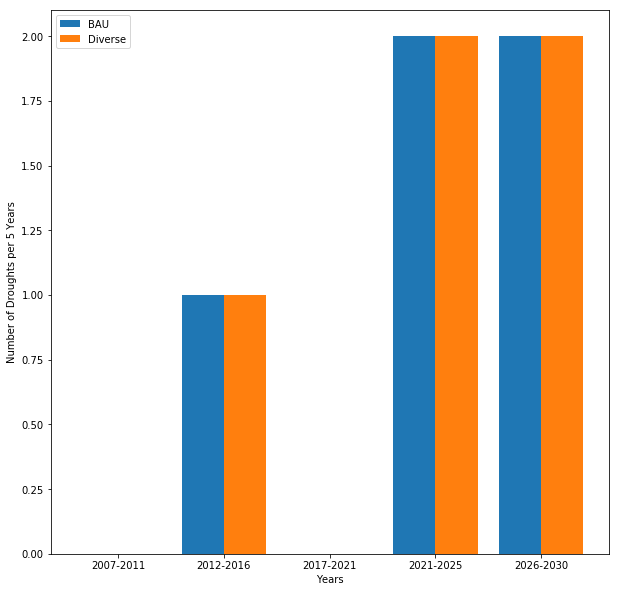

In [39]:
# Bar chart of avg droughts over time intervals

f, ax1 = plt.subplots(figsize=(10,10))

bau_drought_tracker = np.zeros(time) #Variable for counting number of BAU droughts in year t across simulations
diverse_drought_tracker = np.zeros(time) #Variable for counting number of Diverse droughts in year t across simulations
bins = int(time / 10)
bau_drought_bins = np.zeros(bins) #Creating bins of 10 timesteps for drought plot
diverse_drought_bins = np.zeros(bins) #Creating bins of 10 timesteps for diverse drought plot

for a in range(simulations):

    for t in range(time):
        b = int(t/ 10)
        if sim_bau_drought_status[-1,-1,a,t] == 1:
            bau_drought_tracker[t] += 1
            bau_drought_bins[b] += 1
        if sim_diverse_drought_status[-1,-1,a,t] == 1:
            diverse_drought_tracker[t] += 1
            diverse_drought_bins[b] += 1
    
    #axs[0].plot(np.arange(time), sim_diverse_proportion[a,:], label='Diverse')
    #axs[1].plot(np.arange(time), sim_migrate_proportion[a,:], label='Migrate')

#axs[2].hist(sim_migrant_proportion[:,-1], bins=5)

ax1.bar(np.arange(bins)-0.2, bau_drought_bins / simulations, width=0.4, label='BAU')
ax1.bar(np.arange(bins)+0.2, diverse_drought_bins / simulations, width=0.4, label='Diverse')    
#axs[0].set_xlabel('Time')
#axs[0].set_ylabel('Proportion of Households Adopting Diverse Strategy')

#axs[1].set_xlabel('Time')
#axs[1].set_ylabel('Proportion of Households Adopting Migration Strategy')

#axs[2].set_xlabel('Final Migration Proportion')
#axs[2].set_ylabel('Frequency')

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Droughts per 5 Years')
ax1.set_xticklabels(['test', '2007-2011', '2012-2016', '2017-2021', '2021-2025', '2026-2030', '2031-2035'])

plt.legend()

plt.show()





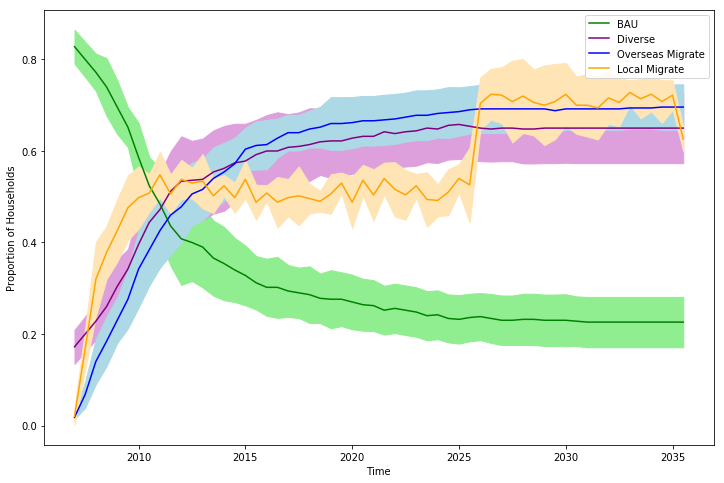

In [43]:
##### Distributed Decision-Making - Household Strategies

#Load previously-saved data if applicable
#simulations = 100
#total_pop = 100 * 5
#sim_migrant_proportion = np.load('Layer3_v5_migrants.npy')
#sim_gini = np.load('Layer3_v5_gini.npy')
#sim_household_size = np.load('Layer3_v5_Householdsize.npy')
#sim_household_income = np.load('Layer3_v5_income.npy')
#sim_education_status = np.load('Layer2_v3_educationstatus.npy')

x = 2007 + np.arange(time)/2

avg_bau_proportion = np.zeros(time)
std_bau_proportion = np.zeros(time)
avg_diverse_proportion = np.zeros(time)
std_diverse_proportion = np.zeros(time)
avg_overseas_migrate_proportion = np.zeros(time)
std_overseas_migrate_proportion = np.zeros(time)
avg_local_migrate_proportion = np.zeros(time)
std_local_migrate_proportion = np.zeros(time)

sim_combined_migrate_proportion = np.zeros((simulations,time))
avg_combined_migrate_proportion = np.zeros(time)
std_combined_migrate_proportion = np.zeros(time)


for t in range(time):
    avg_bau_proportion[t] = np.average(sim_bau_proportion[-1,-1,:,t])
    std_bau_proportion[t] = np.std(sim_bau_proportion[-1,-1,:,t])
    
    avg_diverse_proportion[t] = np.average(sim_diverse_proportion[-1,-1,:,t])
    std_diverse_proportion[t] = np.std(sim_diverse_proportion[-1,-1,:,t])

    avg_overseas_migrate_proportion[t] = np.average(sim_overseas_migrate_proportion[-1,-1,:,t])
    std_overseas_migrate_proportion[t] = np.std(sim_overseas_migrate_proportion[-1,-1,:,t])
    
    avg_local_migrate_proportion[t] = np.average(sim_local_migrate_proportion[-1,-1,:,t])
    std_local_migrate_proportion[t] = np.std(sim_local_migrate_proportion[-1,-1,:,t])
    
    for a in range(simulations):
        sim_combined_migrate_proportion[a,t] = np.count_nonzero(sim_household_size[a,t,:] != starting_size)
    
    avg_combined_migrate_proportion[t] = np.average(sim_combined_migrate_proportion[:,t] / households)
    std_combined_migrate_proportion[t] = np.std(sim_combined_migrate_proportion[:,t] / households)



f, ax1 = plt.subplots(figsize=(12,8))
ax1.set_xlabel('Time')
ax1.set_ylabel('Proportion of Households')
ax1.plot(x, avg_bau_proportion, label='BAU', color='Green')
ax1.fill_between(x, avg_bau_proportion - std_bau_proportion, avg_bau_proportion + std_bau_proportion, color='lightgreen')
ax1.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
ax1.fill_between(x, avg_diverse_proportion - std_diverse_proportion, avg_diverse_proportion + std_diverse_proportion, color='plum')
ax1.plot(x, avg_overseas_migrate_proportion, label='Overseas Migrate', color='blue')
ax1.fill_between(x, avg_overseas_migrate_proportion - std_overseas_migrate_proportion, avg_overseas_migrate_proportion + std_overseas_migrate_proportion, color='lightblue')
ax1.plot(x, avg_local_migrate_proportion, label='Local Migrate', color='orange')
ax1.fill_between(x, avg_local_migrate_proportion - std_local_migrate_proportion, avg_local_migrate_proportion + std_local_migrate_proportion, color='moccasin')
#ax1.plot(x, avg_combined_migrate_proportion, label='Combined Migrate', color='grey')
#ax1.fill_between(x,avg_combined_migrate_proportion - std_combined_migrate_proportion, avg_combined_migrate_proportion + std_combined_migrate_proportion, color = 'lightsteelblue')
plt.legend()

plt.show()


#plt.savefig('Layer4_RemBank_strategies.eps', bbox_inches='tight')

#print('Layer4 RemBank BAU Households:', avg_bau_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 RemBank Diverse Households:', avg_diverse_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 RemBank Overseas Migrate Households:', avg_overseas_migrate_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 RemBank Local Migrate Households:', avg_local_migrate_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 RemBank Combined Migrate Households:', avg_combined_migrate_proportion[-1], file=open('ModelLayers.txt', 'a'))






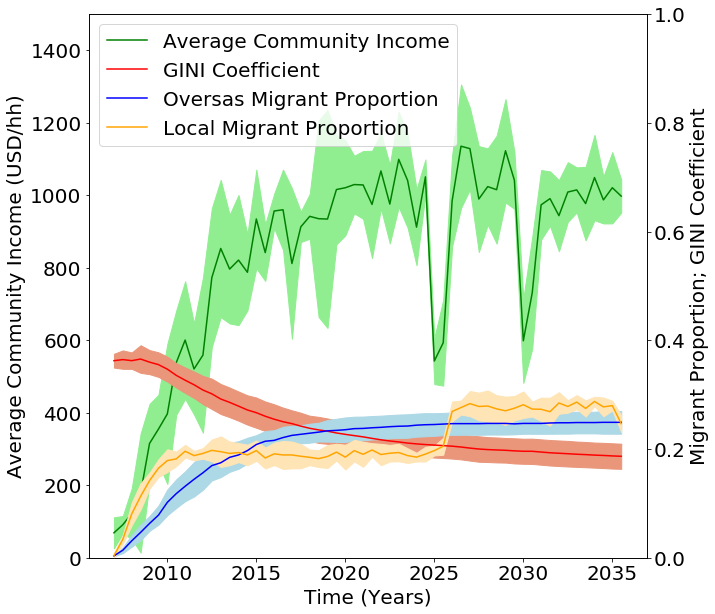

In [44]:
#Layer 4 - Adaptation outcomes
x = 2007 + np.arange(time) / 2

#Load previously saved data if applicable
#simulations = 1
#sim_avg_community_income = np.load('Layer3_income.npy')
#sim_gini = np.load('Layer3_gini.npy')

#sim_overseas_migrant_proportion = np.load('Layer3_Overseasmigrants.npy')
#sim_local_migrant_proportion = np.load('Layer3_Localmigrants.npy')


avg_overseas_migrant_proportion = np.zeros(time)
std_overseas_migrant_proportion = np.zeros(time)

avg_local_migrant_proportion = np.zeros(time)
std_local_migrant_proportion = np.zeros(time)

avg_household_income = np.zeros((simulations, time))
avg_community_income = np.zeros(time)
std_community_income = np.zeros(time)

avg_household_savings = np.zeros((simulations, time))
avg_community_savings = np.zeros(time)
avg_gini_coef = np.zeros(time)
std_gini_coef = np.zeros(time)

tert_avg_migration = np.zeros(time)
second_avg_migration = np.zeros(time)
primary_avg_migration = np.zeros(time)

    
    

for t in range(time):
    avg_overseas_migrant_proportion[t] = np.average(sim_overseas_migrant_proportion[-1,-1,:,t])
    std_overseas_migrant_proportion[t] = np.std(sim_overseas_migrant_proportion[-1,-1,:,t])
    
    avg_local_migrant_proportion[t] = np.average(sim_local_migrant_proportion[-1,-1,:,t])
    std_local_migrant_proportion[t] = np.std(sim_local_migrant_proportion[-1,-1,:,t])
    
    for a in range(simulations):
        avg_household_income[a,t] = np.average(sim_avg_community_income[-1, -1, a,t])
    avg_community_income[t] = np.average(avg_household_income[:,t])
    std_community_income[t] = np.std(avg_household_income[:,t])

    
    avg_gini_coef[t] = np.average(sim_gini[-1,-1,:,t])
    std_gini_coef[t] = np.std(sim_gini[-1,-1,:,t])

    
    tert_migration = 0
    second_migration = 0
    primary_migration = 0
    
    #for a in range(simulations):
        #tracker = sim_household_migrants[a]
        
        #for i in range(households):
            #if sim_education_status[a][i] == 'Tertiary':
                #tert_migration += tracker[b,i]
            #elif sim_education_status[a][i] == 'Secondary':
                #second_migration += tracker[b,i]
            #else:
                #primary_migration += tracker[b,i]

    #tert_avg_migration[b] = tert_migration / (simulations * total_pop)
    #second_avg_migration[b] = second_migration / (simulations * total_pop)
    #primary_avg_migration[b] = primary_migration / (simulations * total_pop)

#y = np.row_stack((primary_avg_migration, second_avg_migration, tert_avg_migration))
#y_stack = np.cumsum(y, axis=0)


f, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel('Time (Years)', size=20)
ax1.set_ylabel('Average Community Income (USD/hh)', size=20)
ax1.plot(x, avg_community_income, label='Average Community Income', color='Green')
ax1.fill_between(x, avg_community_income - std_community_income, avg_community_income + std_community_income, color='lightgreen')
plt.xticks(size=20)
plt.yticks(size=20)
ax2=ax1.twinx()

ax2.plot(x, avg_gini_coef, label='GINI Coefficient', color='Red')
ax2.fill_between(x, avg_gini_coef - std_gini_coef, avg_gini_coef + std_gini_coef, color='darksalmon')

ax2.plot(x, avg_overseas_migrant_proportion, label='Oversas Migrant Proportion', color='blue')
ax2.fill_between(x, avg_overseas_migrant_proportion - std_overseas_migrant_proportion, avg_overseas_migrant_proportion + std_overseas_migrant_proportion, color='lightblue')

ax2.plot(x, avg_local_migrant_proportion, label='Local Migrant Proportion', color='orange')
ax2.fill_between(x, avg_local_migrant_proportion - std_local_migrant_proportion, avg_local_migrant_proportion + std_local_migrant_proportion, color='moccasin')

ax2.set_ylabel('Migrant Proportion; GINI Coefficient', size=20)



#ax2.plot(x, avg_migrant_proportion, label='Average Migration Proportion', color='Blue')


ax2.set_ylim([0,1])
ax1.set_ylim([0,1500])

#ax2.legend(loc=0)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=20)

plt.yticks(size=20)
plt.show()



#plt.savefig('Layer3_outcomes_square.eps', bbox_inches='tight')


#print('Layer4 RemBank Final Income:', avg_community_income[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 RemBank Final Overseas Migrant Proportion:', avg_overseas_migrant_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 RemBank Final Local Migrant Proportion:', avg_local_migrant_proportion[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 RemBank GINI Proportion:', avg_gini_coef[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 Secondary Migrants:', second_avg_migration[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer2 v3 Tertiary Migrants:', tert_avg_migration[-1], file=open('ModelLayers.txt', 'a'))




In [10]:
#Function to count length of consecutive numbers (to determine migrant length)

def consec_count(listrand):
    count=1
    consec_list=[]
    
    if len(listrand) == 1:
        consec_list.append(count)
    else:
        for i in range(len(listrand[:-1])):
            if listrand[i]+1 == listrand[i+1]:
                count+=1
                if i == (len(listrand[:-1]) - 1):
                    consec_list.append(count)
            else:
                consec_list.append(count)
                count=1
            

    return consec_list

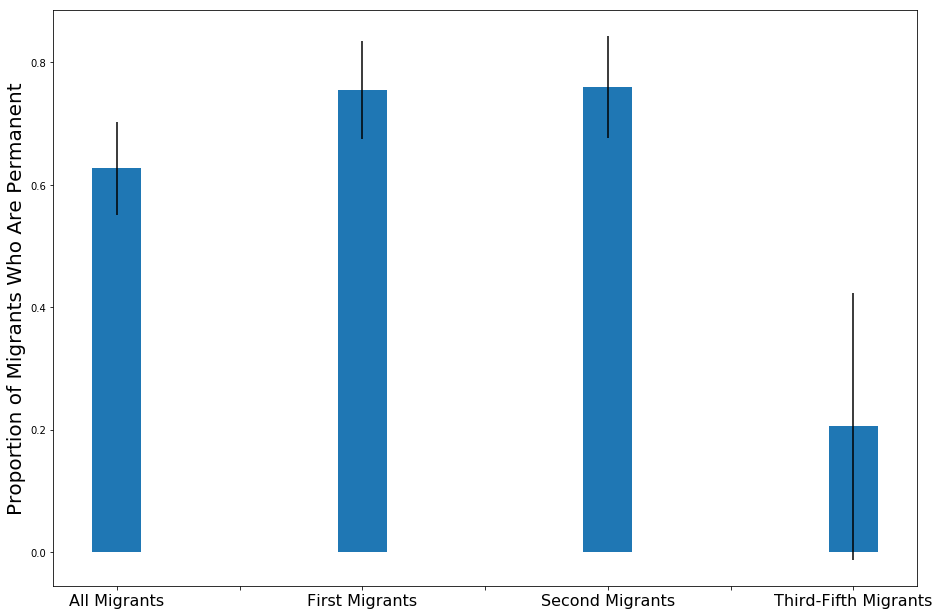

In [11]:
#Proportion of migrants that are permanent migrants

household_size = np.load('Layer4_v4_Householdsize.npy')
simulations = len(household_size)
time = len(household_size[-1])
households = len(household_size[-1][-1])


permanent_migrants = np.zeros((simulations, households))
temp_migrants = np.zeros((simulations, households))

migrant_breakdown_perm = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': [], 'third-fifth':[]}
migrant_breakdown_all = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': [], 'third-fifth':[]}
migrant_breakdown_prop = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': [], 'third-fifth':[]}

all_migrants = np.zeros((simulations, households))
perm_proportion = np.zeros(simulations)


for a in range(simulations):
    for i in range(households):
        permanent_migrants[a,i] = labor_max - household_size[a,-1,i]
        all_migrants[a,i] = labor_max - np.amin(household_size[a,:,i]) 
        temp_migrants[a,i] = all_migrants[a,i] - permanent_migrants[a,i]
    
    perm_proportion[a] = np.sum(permanent_migrants[a,:]) / np.sum(all_migrants[a,:])
    
    for i, key in enumerate(migrant_breakdown_perm.keys()):
        migrant_breakdown_perm[key].append(np.count_nonzero(permanent_migrants[a,:] > i))
        migrant_breakdown_all[key].append(np.count_nonzero(all_migrants[a,:] > i)) 
        if migrant_breakdown_all[key][-1] == 0:
            migrant_breakdown_all[key][-1] = 1
        migrant_breakdown_prop[key].append(migrant_breakdown_perm[key][-1] / migrant_breakdown_all[key][-1])
    
    migrant_breakdown_perm['third-fifth'].append(migrant_breakdown_perm['third'][-1] + migrant_breakdown_perm['fourth'][-1] + migrant_breakdown_perm['fifth'][-1])
    migrant_breakdown_all['third-fifth'].append(migrant_breakdown_all['third'][-1] + migrant_breakdown_all['fourth'][-1] + migrant_breakdown_all['fifth'][-1])
    migrant_breakdown_prop['third-fifth'].append(migrant_breakdown_perm['third-fifth'][-1] / migrant_breakdown_all['third-fifth'][-1])

means = [np.average(perm_proportion), 0, np.average(migrant_breakdown_prop['first']), 0, np.average(migrant_breakdown_prop['second']), 0, np.average(migrant_breakdown_prop['third-fifth'])]
error = [np.std(perm_proportion), 0, np.std(migrant_breakdown_prop['first']), 0, np.std(migrant_breakdown_prop['second']), 0, np.std(migrant_breakdown_prop['third-fifth'])]

categories = np.arange(len(means))
proportion_std = np.std(perm_proportion)
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(categories, means, yerr = error, width = 0.4)

ax.set_ylabel('Proportion of Migrants Who Are Permanent', fontsize=20)
ax.set_xticklabels(['test', 'All Migrants', '', 'First Migrants','', 'Second Migrants', '','Third-Fifth Migrants'], fontsize=16)
plt.legend()

plt.show()

#plt.savefig('Permanent_migrants.eps', bbox_inches='tight')

39.5926346897
36.1526781904
0.6053648556490111


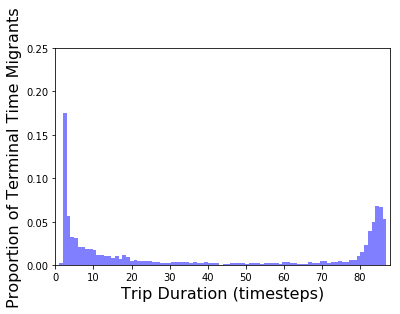

In [38]:
#Histogram of migrants by duration of migration period (in cropping cycles)

simulations = 100
ensemble_first_migrant_length = []
ensemble_second_migrant_length = []
ensemble_second_migrant_length = []
ensemble_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
ens_migrants = []
ens_trip_count = []
ens_perm_trip_count = []
ens_perm_migrants = []

final_migrants = np.zeros((simulations, households))
full_migrants = np.zeros((simulations, households))


#Tracking times of migrant departure and migrant return for each simulation
household_size = np.load('Temp3Risk125_Householdsize.npy')
final_perm_duration = [] #List of final trip lengths for migrants away at terminal time

for a in range(simulations):
    simulation_first_migrant_length = []
    simulation_second_migrant_length = []
    simulation_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
    sim_migrants = []
    sim_perm_migrants = []
    household_trip_count = []
    household_perm_trip_count = []
    
    for i in range(households):
        final_migrants[a,i] = labor_max - household_size[a,-1,i]
        full_migrants[a,i] = labor_max - np.amin(household_size[a,:,i])
        
        household_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
        household_perm_migrants = {'first': [], 'second': [], 'third': [], 'fourth': [], 'fifth': []}
        household_first_migrant = []      
        household_second_migrant = []
        household_third_migrant = []
        household_fourth_migrant = []
        household_fifth_migrant = []
    
        
        for t in range(1, time):
            if household_size[a,t,i] < labor_max:
                household_first_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 1):
                household_second_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 2):
                household_third_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 3):
                household_fourth_migrant.append(t)
            if household_size[a,t,i] < (labor_max - 4):
                household_fifth_migrant.append(t)
        
        household_migrants['first'].append(consec_count(household_first_migrant))
        household_migrants['second'].append(consec_count(household_second_migrant))
        household_migrants['third'].append(consec_count(household_third_migrant))
        household_migrants['fourth'].append(consec_count(household_fourth_migrant))
        household_migrants['fifth'].append(consec_count(household_fifth_migrant))
        

        #Only get the temporary migrants
        for j, key in enumerate(household_migrants.keys(), start=1):
            if final_migrants[a,i] >= j: #i.e. migrant is away at terminal time
                household_perm_migrants[key].append(household_migrants[key][-1]) #All trip lengths for household_migrants at destination by terminal time
                final_perm_duration.append(household_migrants[key][-1][-1]) #Last trip length for household migrant away at terminal time
                del household_migrants[key][-1]
                
                
        total_migrants = household_migrants['first'] + household_migrants['second'] + household_migrants['third'] + household_migrants['fourth'] + household_migrants['fifth']
        total_household_perm_migrants = household_perm_migrants['first'] + household_perm_migrants['second'] + household_perm_migrants['third'] + household_perm_migrants['fourth'] + household_perm_migrants['fifth']
        
        total_flat = [item for sublist in total_migrants for item in sublist]
        household_trip_count.append(len(total_flat))
        
        total_perm_flat = [item for sublist in total_household_perm_migrants for item in sublist]
        household_perm_trip_count.append(len(total_perm_flat))
        
        sim_migrants.append(total_flat)
        sim_perm_migrants.append(total_perm_flat)
        

    total_sim = [item for sublist in sim_migrants for item in sublist]
    ens_migrants.append(total_sim)
    
    total_perm_sim = [item for sublist in sim_perm_migrants for item in sublist]
    ens_perm_migrants.append(total_perm_sim)
    
    ens_trip_count.append(household_trip_count)
    ens_perm_trip_count.append(household_perm_trip_count)

print(np.average(final_perm_duration))
print(np.std(final_perm_duration))
print(sum(map(lambda x : x>10, final_perm_duration))/len(final_perm_duration))

final_migrant_dist = [item for sublist in ens_migrants for item in sublist]
final_trip_count_dist = [item for sublist in ens_trip_count for item in sublist]

final_perm_migrant_dist = [item for sublist in ens_perm_migrants for item in sublist]
final_perm_trip_count = [item for sublist in ens_perm_trip_count for item in sublist]


num_bins = int(time)
n, bins, patches = plt.hist(final_perm_duration, num_bins, facecolor='blue', weights=(np.ones(len(final_perm_duration)) / len(final_perm_duration)), alpha=0.5)

plt.xlim(xmin=0, xmax = 88)
plt.ylim(ymin=0, ymax=0.25)
plt.xlabel('Trip Duration (timesteps)', fontsize=16)
plt.ylabel('Proportion of Terminal Time Migrants', fontsize=16)
plt.show()

#plt.savefig('Layer4_v5_finalmigrantduration.eps')



In [188]:
#Comparison of terminal time strategy distributions by policy
t = -1 #Denotes terminal time results (year = 2050)

#Load previously saved data 

base_bau = np.load('Layer4_BAUproportion.npy')
base_diverse = np.load('Layer4_Diverseproportion.npy')
base_overseas_migrate = np.load('Layer4_Overseasmigrateproportion.npy')
base_local_migrate = np.load('Layer4_Localmigrateproportion.npy')

cash_bau = np.load('Layer4_Cash_BAUproportion.npy')
cash_diverse = np.load('Layer4_Cash_Diverseproportion.npy')
cash_overseas_migrate = np.load('Layer4_Cash_Overseasmigrateproportion.npy')
cash_local_migrate = np.load('Layer4_Cash_Localmigrateproportion.npy')

ins_bau = np.load('Layer4_Insurance_BAUproportion.npy')
ins_diverse = np.load('Layer4_Insurance_Diverseproportion.npy')
ins_overseas_migrate = np.load('Layer4_Insurance_Overseasmigrateproportion.npy')
ins_local_migrate = np.load('Layer4_Insurance_Localmigrateproportion.npy')

rem_bau = np.load('Layer4_RemBank_BAUproportion.npy')
rem_diverse = np.load('Layer4_RemBank_Diverseproportion.npy')
rem_overseas_migrate = np.load('Layer4_RemBank_Overseasmigrateproportion.npy')
rem_local_migrate = np.load('Layer4_RemBank_Localmigrateproportion.npy')

special_bau = np.load('Layer4_All3_BAUproportion.npy')
special_diverse = np.load('Layer4_All3_Diverseproportion.npy')
special_overseas_migrate = np.load('Layer4_All3_Overseasmigrateproportion.npy')
special_local_migrate = np.load('Layer4_All3_Localmigrateproportion.npy')


base_bau_share = np.average(base_bau[-1,-1,:,t])
base_diverse_share = np.average(base_diverse[-1,-1,:,t])
base_diverse_std = np.std(base_diverse[-1,-1,:,t])
base_overseas_migrate_share = np.average(base_overseas_migrate[-1,-1,:,t])
base_overseas_migrate_std = np.std(base_overseas_migrate[-1,-1,:,t])
base_local_migrate_share = np.average(base_local_migrate[-1,-1,:,t])
base_local_migrate_std = np.std(base_local_migrate[-1,-1,:,t])
#base_avg_utility = np.average(base_utility[-1,-1,:,t])

cash_bau_share = np.average(cash_bau[-1,-1,:,t])
cash_diverse_share = np.average(cash_diverse[-1,-1,:,t])
cash_diverse_std = np.std(cash_diverse[-1,-1,:,t])
cash_overseas_migrate_share = np.average(cash_overseas_migrate[-1,-1,:,t])
cash_overseas_migrate_std = np.std(cash_overseas_migrate[-1,-1,:,t])
cash_local_migrate_share = np.average(cash_local_migrate[-1,-1,:,t])
cash_local_migrate_std = np.std(cash_local_migrate[-1,-1,:,t])
#cash_avg_utility = np.average(cash_utility[-1,-1,:,t])

ins_bau_share = np.average(ins_bau[-1,-1,:,t])
ins_diverse_share = np.average(ins_diverse[-1,-1,:,t])
ins_diverse_std = np.std(ins_diverse[-1,-1,:,t])
ins_overseas_migrate_share = np.average(ins_overseas_migrate[-1,-1,:,t])
ins_overseas_migrate_std = np.std(ins_overseas_migrate[-1,-1,:,t])
ins_local_migrate_share = np.average(ins_local_migrate[-1,-1,:,t])
ins_local_migrate_std = np.std(ins_local_migrate[-1,-1,:,t])
#ins_avg_utility = np.average(ins_utility[-1,-1,:,t])

rem_bau_share = np.average(rem_bau[-1,-1,:,t])
rem_diverse_share = np.average(rem_diverse[-1,-1,:,t])
rem_diverse_std = np.std(rem_diverse[-1,-1,:,t])
rem_overseas_migrate_share = np.average(rem_overseas_migrate[-1,-1,:,t])
rem_overseas_migrate_std = np.std(rem_overseas_migrate[-1,-1,:,t])
rem_local_migrate_share = np.average(rem_local_migrate[-1,-1,:,t])
rem_local_migrate_std = np.std(rem_local_migrate[-1,-1,:,t])
#rem_avg_utility = np.average(rem_utility[-1,-1,:,t])

special_bau_share = np.average(special_bau[-1,-1,:,t])
special_bau_std = np.average(special_bau[-1,-1,:,t])
special_diverse_share = np.average(special_diverse[-1,-1,:,t])
special_diverse_std = np.std(special_diverse[-1,-1,:,t])
special_overseas_migrate_share = np.average(special_overseas_migrate[-1,-1,:,t])
special_overseas_migrate_std = np.std(special_overseas_migrate[-1,-1,:,t])
special_local_migrate_share = np.average(special_local_migrate[-1,-1,:,t])
special_local_migrate_std = np.std(special_local_migrate[-1,-1,:,t])
#special_avg_utility = np.average(special_utility[-1,-1,:,t])

categories = np.arange(10)
bau_means = [base_bau_share, 0, cash_bau_share, 0, ins_bau_share, 0, rem_bau_share, 0, special_bau_share, 0]
diverse_means = [base_diverse_share, 0, cash_diverse_share, 0, ins_diverse_share, 0, rem_diverse_share, 0, special_diverse_share, 0]
diverse_err = [base_diverse_std, 0, cash_diverse_std, 0, ins_diverse_std, 0, rem_diverse_std, 0, special_diverse_std, 0]
overseas_migrate_means = [base_overseas_migrate_share, 0, cash_overseas_migrate_share, 0, ins_overseas_migrate_share, 0, rem_overseas_migrate_share, 0, special_overseas_migrate_share, 0]
overseas_migrate_err = [base_overseas_migrate_std, 0, cash_overseas_migrate_std, 0, ins_overseas_migrate_std, 0, rem_overseas_migrate_std, 0, special_overseas_migrate_std, 0]

local_migrate_means = [base_local_migrate_share, 0, cash_local_migrate_share, 0, ins_local_migrate_share, 0, rem_local_migrate_share, 0, special_local_migrate_share, 0]
local_migrate_err = [base_local_migrate_std, 0, cash_local_migrate_std, 0, ins_local_migrate_std, 0, rem_local_migrate_std, 0, special_local_migrate_std, 0]


#width = 0.35
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(categories - 0.5, bau_means, 0.4, color='green', label='BAU')
ax.bar(categories, overseas_migrate_means, 0.4, yerr = overseas_migrate_err, color='blue', label='Overseas Migrate')
ax.bar(categories + 0.5, local_migrate_means, 0.4, yerr = local_migrate_err, color='orange', label='Local Migrate')
ax.bar(categories - 0.5, diverse_means, 0.4, yerr = diverse_err, bottom=bau_means, color='purple', label='Cash Crop')



ax.set_ylabel('Proportion of Households', fontsize=18)

ax.set_xlabel('Policy Case', fontsize=18)
ax.set_xticklabels(['test', 'Baseline', 'Cash Transfer', 'Insurance', 'Rem Bank', 'All 3'], fontsize=18)
plt.yticks(size=18)
plt.legend(fontsize=16, loc='upper right')

#plt.show()

plt.savefig('Temp15Risk05_policycomparison.eps', bbox_inches='tight')

#print('Optimal BAU Share:', optimal_bau_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Optimal Diverse Share:', optimal_diverse_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Optimal Migrate Share:', optimal_migrate_share, file=open('PolicyScenarios_Temp5.txt', 'a'))
#print('Optimal Social Utility:', optimal_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

print('Base Case BAU Share:', base_bau_share, file=open('PolicyScenarios.txt', 'a'))
print('Base Case Diverse Share:', base_diverse_share, file=open('PolicyScenarios.txt', 'a'))
print('Base Case Overseas Migrate Share:', base_overseas_migrate_share, file=open('PolicyScenarios.txt', 'a'))
print('Base Case Local Migrate Share:', base_local_migrate_share, file=open('PolicyScenarios.txt', 'a'))
#print('Base Case Social Utility:', base_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

print('Cash Transfer BAU Share:', cash_bau_share, file=open('PolicyScenarios.txt', 'a'))
print('Cash Transfer Diverse Share:', cash_diverse_share, file=open('PolicyScenarios.txt', 'a'))
print('Cash Transfer Overseas Migrate Share:', cash_overseas_migrate_share, file=open('PolicyScenarios.txt', 'a'))
print('Cash Transfer Local Migrate Share:', cash_local_migrate_share, file=open('PolicyScenarios.txt', 'a'))
#print('Cash Transfer Social Utility:', cash_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

print('Insurance BAU Share:', ins_bau_share, file=open('PolicyScenarios.txt', 'a'))
print('Insurance Diverse Share:', ins_diverse_share, file=open('PolicyScenarios.txt', 'a'))
print('Insurance Overseas Migrate Share:', ins_overseas_migrate_share, file=open('PolicyScenarios.txt', 'a'))
print('Insurance Local Migrate Share:', ins_local_migrate_share, file=open('PolicyScenarios.txt', 'a'))
#print('Insurance Social Utility:', ins_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

print('Rem Bank BAU Share:', rem_bau_share, file=open('PolicyScenarios.txt', 'a'))
print('Rem Bank Diverse Share:', rem_diverse_share, file=open('PolicyScenarios.txt', 'a'))
print('Rem Bank Overseas Migrate Share:', rem_overseas_migrate_share, file=open('PolicyScenarios.txt', 'a'))
print('Rem Bank Local Migrate Share:', rem_local_migrate_share, file=open('PolicyScenarios.txt', 'a'))
#print('Rem Bank Social Utility:', rem_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))

print('All 3 BAU Share:', special_bau_share, file=open('PolicyScenarios.txt', 'a'))
print('All 3 Diverse Share:', special_diverse_share, file=open('PolicyScenarios.txt', 'a'))
print('All 3 Overseas Migrate Share:', special_overseas_migrate_share, file=open('PolicyScenarios.txt', 'a'))
print('All 3 Local Migrate Share:', special_local_migrate_share, file=open('PolicyScenarios.txt', 'a'))
#print('Cash + Insurance Social Utility:', special_avg_utility, file=open('PolicyScenarios_Temp5.txt', 'a'))


#print('Base Case Diverse Share:', diverse_means, file=open('PolicyScenarios.txt', 'a'))
#print('Base Case Migrate Share:', migrate_means, file=open('PolicyScenarios.txt', 'a'))



In [217]:
#Raincloud Plot - Policy Effects

import seaborn as sns
import pandas as pd
import ptitprince
import os
simulations = 100
households = 100

bau_quantity = np.zeros(simulations)
cash_quantity = np.zeros(simulations)
insurance_quantity = np.zeros(simulations)
rembank_quantity = np.zeros(simulations)
special_quantity = np.zeros(simulations)

policies = [''] * simulations * 5



bau = np.load('Layer4_gini.npy')
cash = np.load('Layer4_Cash_gini.npy')
insurance = np.load('Layer4_Insurance_gini.npy')
rembank = np.load('Layer4_RemBank_gini.npy')
special = np.load('Layer4_All3_gini.npy')


for a in range(simulations):
    
    #For income
    #bau_quantity[a] = np.average(bau[a,-1,:])
    #cash_quantity[a] = np.average(cash[a,-1,:])
    #insurance_quantity[a] = np.average(insurance[a,-1,:])
    #rembank_quantity[a] = np.average(rembank[a,-1,:])
    #special_quantity[a] = np.average(special[a,-1,:])
    
    #For gini/migrants
    bau_quantity[a] = bau[-1,-1,a,-1]
    cash_quantity[a] = cash[-1,-1,a,-1]
    insurance_quantity[a] = insurance[-1,-1,a,-1]
    rembank_quantity[a] = rembank[-1,-1,a,-1]
    special_quantity[a] = special[-1,-1,a,-1]
    
    #For savings
    #bau_quantity[a] = np.count_nonzero(bau[a,-1,:] < migration_cost) / households
    #cash_quantity[a] = np.count_nonzero(cash[a,-1,:] < migration_cost) / households
    #insurance_quantity[a] = np.count_nonzero(insurance[a,-1,:] < migration_cost) / households
    #rembank_quantity[a] = np.count_nonzero(rembank[a,-1,:] < migration_cost) / households
    #special_quantity[a] = np.count_nonzero(special[a,-1,:] < migration_cost) / households
    
        
        
    policies[a] = 'Baseline'
    policies[simulations+a] = 'Cash Transfer'
    policies[2*simulations+a] = 'Insurance'
    policies[3*simulations+a] = 'Rem Bank'
    policies[4*simulations+a] = 'All 3'


avg_bau_quantity = np.average(bau_quantity)
avg_cash_quantity = np.average(cash_quantity)
avg_insurance_quantity = np.average(insurance_quantity)
avg_rembank_quantity = np.average(rembank_quantity)
avg_special_quantity = np.average(special_quantity)

avg_quantities = [avg_bau_quantity, avg_cash_quantity, avg_insurance_quantity, avg_rembank_quantity, avg_special_quantity]


strategy_data = np.concatenate((bau_quantity, cash_quantity, insurance_quantity, rembank_quantity, special_quantity), axis=None)

strategy_df = pd.DataFrame({'GINI Coefficient': strategy_data, 'Policy': policies})
sns.set(style="white", font_scale=1.5)
dx = "Policy"; dy = "GINI Coefficient"; ort="h"; sigma=0.2; pal="Set2"
                                     
ax=ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, bw=sigma, palette = pal, width_viol=0.6, figsize= (8,6), orient=ort)
#ax.set_xlim([0, 0.5])
ax.set_ylabel('Policy Case', size=20)
ax.set_xlabel('GINI Coefficient', size=20)
plt.xticks(fontsize=20)

#plt.show()

plt.savefig('Temp15Risk05_gini_RainCloud.eps', bbox_inches='tight')
#print('Temp15Risk05 Avg Household Income:', avg_quantities, file=open('PolicyEffects.txt', 'a'))


In [ ]:
#Raincloud Plots for distribution of households by savings

import seaborn as sns
import pandas as pd
import ptitprince
import os
simulations = 100
households = 100

bau_quantity = np.zeros((simulations, households))
cash_quantity = np.zeros((simulations,households))
insurance_quantity = np.zeros((simulations,households))
rembank_quantity = np.zeros((simulations,households))
special_quantity = np.zeros((simulations,households))

policies = [''] * simulations * households * 5



bau = np.load('Temp45Risk025_savings.npy')
cash = np.load('Temp45Risk025_Cash_savings.npy')
insurance = np.load('Temp45Risk025_Insurance_savings.npy')
rembank = np.load('Temp45Risk025_RemBank_savings.npy')
special = np.load('Temp45Risk025_All3_savings.npy')


for a in range(simulations):
    
    #For income
    #bau_quantity[a] = np.average(bau[a,-1,:])
    #cash_quantity[a] = np.average(cash[a,-1,:])
    #insurance_quantity[a] = np.average(insurance[a,-1,:])
    #rembank_quantity[a] = np.average(rembank[a,-1,:])
    #special_quantity[a] = np.average(special[a,-1,:])
    
    #For gini/migrants
    #bau_quantity[a] = bau[-1,-1,a,-1]
    #cash_quantity[a] = cash[-1,-1,a,-1]
    #insurance_quantity[a] = insurance[-1,-1,a,-1]
    #rembank_quantity[a] = rembank[-1,-1,a,-1]
    #special_quantity[a] = special[-1,-1,a,-1]
    
    #For savings
    #bau_quantity[a] = np.count_nonzero(bau[a,-1,:] < migration_cost) / households
    #cash_quantity[a] = np.count_nonzero(cash[a,-1,:] < migration_cost) / households
    #insurance_quantity[a] = np.count_nonzero(insurance[a,-1,:] < migration_cost) / households
    #rembank_quantity[a] = np.count_nonzero(rembank[a,-1,:] < migration_cost) / households
    #special_quantity[a] = np.count_nonzero(special[a,-1,:] < migration_cost) / households
    
    for i in range(households):
        bau_quantity[a] = bau[a,-1,i]
        cash_quantity[a] = cash[a,-1,i]
        insurance_quantity[a] = insurance[a,-1,i]
        rembank_quantity[a] = rembank[a,-1,i]
        special_quantity[a] = special[a,-1,i]
        
        
        policies[a*households + i] = 'Baseline'
        policies[simulations*households+a*households+i] = 'Cash Transfer'
        policies[2*simulations*households+a*households+i] = 'Insurance'
        policies[3*simulations*households+a*households+i] = 'Rem Bank'
        policies[4*simulations*households+a*households+i] = 'All 3'

bau_quantity.flatten()
cash_quantity.flatten()
insurance_quantity.flatten()
rembank_quantity.flatten()
special_quantity.flatten()

print(policies.count('Insurance'))

#avg_bau_quantity = np.average(bau_quantity)
#avg_cash_quantity = np.average(cash_quantity)
#avg_insurance_quantity = np.average(insurance_quantity)
#avg_rembank_quantity = np.average(rembank_quantity)
#avg_special_quantity = np.average(special_quantity)

avg_quantities = [avg_bau_quantity, avg_cash_quantity, avg_insurance_quantity, avg_rembank_quantity, avg_special_quantity]


strategy_data = np.concatenate((bau_quantity, cash_quantity, insurance_quantity, rembank_quantity, special_quantity), axis=None)

strategy_df = pd.DataFrame({'GINI Coefficient': strategy_data, 'Policy': policies})
sns.set(style="white", font_scale=1.5)
dx = "Policy"; dy = "GINI Coefficient"; ort="h"; sigma=0.2; pal="Set2"
                                     
ax=ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, bw=sigma, palette = pal, width_viol=0.6, figsize= (8,6), orient=ort)
#ax.set_xlim([0, 0.7])
ax.set_ylabel('Policy Case', size=20)
ax.set_xlabel('Household Savings (USD)', size=20)
plt.xticks(fontsize=16)

plt.show()

#plt.savefig('Temp15Risk05_savingsdistribution_RainCloud.png', bbox_inches='tight')
#print('Temp15Risk05 Average Savings Under mobility:', avg_quantities, file=open('PolicyEffects.txt', 'a'))


In [ ]:
#Violin Plots for distribution of households by number of migrants
from matplotlib import rcParams


households = 100
simulations = 100
time = 88

half = int(time/2)
final = int(time) - 1


initial_migrants = []
year9_migrants = []
halftime_migrants = []
finaltime_migrants = []

bank_initial_migrants= []
bank_year9_migrants = []
bank_halftime_migrants= []
bank_finaltime_migrants= []

household_migrants_0 = []
household_migrants_year9 = []
household_migrants_half = []
household_migrants_final = []

bank_household_migrants_0 = []
bank_household_migrants_year9 = []
bank_household_migrants_half = []
bank_household_migrants_final = []

time_0 = [0] * households * simulations
time_9 = [17] * households * simulations
time_half = [half] * households * simulations
time_final = [final] * households * simulations

hue_base = ['Model'] * households * simulations
hue_bank = ['CVFS Data'] * households * simulations



sim_household_migrants = 5 - np.load('Layer4_v5_Householdsize.npy')

#Separating out base case migration vs. migration with policy option
base_migration = sim_household_migrants[0:simulations]

#bank_migration = sim_household_migrants[-simulations:]



#Y variable column
for a in range(simulations):
    initial_migrants.append(base_migration[a][0])
    year9_migrants.append(base_migration[a][17])
    #halftime_migrants.append(base_migration[a][half])
    finaltime_migrants.append(base_migration[a][final])
    
    #bank_initial_migrants.append(bank_migration[a][0])
    #bank_year9_migrants.append(bank_migration[a][17])
    #bank_halftime_migrants.append(bank_migration[a][half])
    #bank_finaltime_migrants.append(bank_migration[a][final])
    


household_migrants_0 = [item for sublist in initial_migrants for item in sublist]
household_migrants_year9 = [item for sublist in year9_migrants for item in sublist]
#household_migrants_half = [item for sublist in halftime_migrants for item in sublist]
household_migrants_final = [item for sublist in finaltime_migrants for item in sublist]

bank_household_migrants_0 = [0] * households * simulations
bank_household_migrants_final = [0] * households * simulations
#bank_household_migrants_0 = [item for sublist in bank_initial_migrants for item in sublist]


#bank_household_migrants_year9 = [0] * households * simulations

total_data_points = households * simulations
cvfs_household_migrants_9 = np.zeros(total_data_points)

for i in range(total_data_points):
    if i < int((.2816 * total_data_points)):
        cvfs_household_migrants_9[i] = 0
    elif i < int((.2816 + .3228) * total_data_points):
        cvfs_household_migrants_9[i] = 1
    elif i < int((.2816 + .3228 + .1641) * total_data_points):
        cvfs_household_migrants_9[i] = 2
    elif i < int((.2816 + .3228 + .1641+ .1029) * total_data_points):
        cvfs_household_migrants_9[i] = 3
    elif i < int((.2816 + .3228 + .1641+ .1029 + .0661) * total_data_points):
        cvfs_household_migrants_9[i] = 4
    else:
        cvfs_household_migrants_9[i] = 5

model_migrant0 = household_migrants_year9.count(0) / (simulations * households)
model_migrant1 = household_migrants_year9.count(1)/ (simulations * households)
model_migrant2 = household_migrants_year9.count(2)/ (simulations * households)
model_migrant3 = household_migrants_year9.count(3)/ (simulations * households)
model_migrant4 = household_migrants_year9.count(4)/ (simulations * households)
model_migrant5 = household_migrants_year9.count(5)/ (simulations * households)

print((cvfs_household_migrants_9)[5000])
#bank_household_migrants_half = [item for sublist in bank_halftime_migrants for item in sublist]
#bank_household_migrants_final = [item for sublist in bank_finaltime_migrants for item in sublist]


#migrants = np.concatenate((household_migrants_0, household_migrants_year9, household_migrants_half, household_migrants_final, bank_household_migrants_0, bank_household_migrants_year9, bank_household_migrants_half, bank_household_migrants_final), axis=None)
#migrants = np.concatenate((household_migrants_final, bank_household_migrants_final))
migrants = np.concatenate((household_migrants_year9, cvfs_household_migrants_9))
#time_steps = np.concatenate((time_0, time_9, time_half, time_final, time_0, time_9, time_half, time_final), axis=None)
time_steps = np.concatenate((time_9, time_9))
#hues = np.concatenate((hue_base, hue_base, hue_base, hue_base, hue_bank, hue_bank, hue_bank, hue_bank), axis=None)
hues = np.concatenate((hue_base, hue_bank))

migrant_df = pd.DataFrame({'Household Migrants': migrants, 'Time': time_steps, 'Status': hues})

ax = sns.violinplot(x="Time", y="Household Migrants", hue="Status", data=migrant_df, scale="count", split="True", figsize=(10,10))
#ax = sns.violinplot(x="Time", y="Household Migrants", data=migrant_df, scale="count", split="False", figsize=[4,8])
leg = plt.gca().legend()
#leg.remove()
ax.set_ylabel('Migrants per Household', size=20)
ax.set_xlabel('')
plt.legend(loc='center left')
plt.xticks(fontsize=20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(fontsize=20)
ax.set_ylim([0,5])
#sns.set(rc={'figure.figsize':(10,10)})
rcParams['figure.figsize'] = 10,10
#plt.rcParams.update(plt.rcParamsDefault)
plt.show()


#plt.savefig('Validation_migrantsviolin.png', bbox_inches='tight')

#print('Layer 4 v5 0 Migrant Households:', model_migrant0, file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 1 Migrant Households:', model_migrant1, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 2 Migrant Households:', model_migrant2, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 3 Migrant Households:', model_migrant3, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 4 Migrant Households:', model_migrant4, file=open('ModelLayers.txt', 'a'))
#print('Layer 4 v5 5 Migrant Households:', model_migrant5, file=open('ModelLayers.txt', 'a'))

In [31]:
#Horizontal bar plot for distribution of households by number of migrants

#overseas_migrant_data = labor_max - np.load('Layer4_v5_Householdsize.npy')
#education_status = np.load('Layer4_v5_educationstatus.npy')

#simulations = 100
#households = 100
#timestep = 87

migrants = []

migrants_by_education = {'Primary': [], 'Secondary':[], 'Tertiary':[]}

migrant_data = 
for a in range(simulations):
    migrants.append(migrant_data[a][timestep])
    for i in range(households):
        level = education_status[a][i]
        migrants_by_education[level].append(migrant_data[a][timestep][i])
    
flat_migrants = [item for sublist in migrants for item in sublist]

migrant_categories = {'migrant_0':[], 'migrant_1':[], 'migrant_2':[], 'migrant_3':[], 'migrant_4':[], 'migrant_5':[]}
migrant_education_totals = {'Primary':[], 'Secondary':[], 'Tertiary':[]}

for i,key in enumerate(migrant_categories):
    
    migrant_categories[key] = flat_migrants.count(i) / (households * simulations)
    
    for status in migrants_by_education:
        migrant_education_totals[status].append(migrants_by_education[status].count(i) / (households * simulations))

        
fig, ax = plt.subplots(figsize=[5,10])
xpos = np.arange(len(migrant_categories))
yvalues = list(migrant_categories.values())
#ax.bar(xpos, yvalues, align='center')
second_bottom = [first + second for first, second in zip(migrant_education_totals['Primary'], migrant_education_totals['Secondary'])]
ax.bar(xpos, migrant_education_totals['Primary'], align='center', color='green', label='Primary')
ax.bar(xpos, migrant_education_totals['Secondary'], bottom = migrant_education_totals['Primary'], align='center', color='yellow', label='Secondary')
ax.bar(xpos, migrant_education_totals['Tertiary'], bottom = second_bottom, align='center', color='blue', label='Post-Secondary')
ax.set_xticks(xpos)
ax.set_ylim([0,0.65])
ax.set_ylabel('Proportion of Households', size=18)
ax.set_xlabel('Number of Migrants at Terminal Time', size=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.show()

#plt.savefig('Layer4_migrants.eps', bbox_inches='tight')
    

NameError: name 'migrant_data' is not defined

In [66]:
#Validation - Comparison of household distribution by number of migrants with CVFS data

migrant_data = labor_max - np.load('Layer4_v5_Householdsize.npy')
simulations = 100
households = 100
timestep = 17

cvfs_migrant_data = [0.2816, 0.3228, 0.1641, 0.1029, 0.0661, 0.0625]

migrants = []
for a in range(simulations):
    migrants.append(migrant_data[a][timestep])
    
flat_migrants = [item for sublist in migrants for item in sublist]

migrant_categories = {'migrant_0':[], 'migrant_1':[], 'migrant_2':[], 'migrant_3':[], 'migrant_4':[], 'migrant_5':[]}

for i,key in enumerate(migrant_categories):
    migrant_categories[key] = flat_migrants.count(i) / (households * simulations)


bar_width = 0.45
fig, ax = plt.subplots(figsize=[10,10])
xpos = np.arange(len(migrant_categories))
yvalues = list(migrant_categories.values())
ax.bar(xpos - bar_width/2, yvalues, bar_width, color='blue', label='Model')

#Turn On for comparison to CVFS data
ax.bar(xpos+bar_width/2, cvfs_migrant_data, bar_width, color='darkorange', label='CVFS Data')

ax.set_xticks(xpos)
ax.set_ylim([0,0.65])
ax.set_ylabel('Proportion of Households', size=18)
ax.set_xlabel('Number of Migrants at Terminal Time', size=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
#plt.show()

plt.savefig('Validation_migrants.png', bbox_inches='tight')

In [ ]:
# Household Strategies broken down by education level

#Loading data
simulations = 100
sim_farm_strategy = np.load('Layer3_v5_householdfarmstrategies.npy')
sim_household_strategy = np.load('Layer3_v5_householdstrategies.npy')
sim_household_migrants = 5 - np.load('Layer3_v5_Householdsize.npy')
sim_education_status = np.load('Layer3_v5_educationstatus.npy')

tert_bau = np.zeros((simulations, time))
tert_diverse = np.zeros((simulations, time))
tert_migrate = np.zeros((simulations, time))
second_bau = np.zeros((simulations, time))
second_diverse = np.zeros((simulations, time))
second_migrate = np.zeros((simulations, time))
primary_bau = np.zeros((simulations, time))
primary_diverse = np.zeros((simulations, time))
primary_migrate = np.zeros((simulations, time))

tert_bau_avg = np.zeros(time)
tert_diverse_avg = np.zeros(time)
tert_migrate_avg = np.zeros(time)
second_bau_avg = np.zeros(time)
second_diverse_avg = np.zeros(time)
second_migrate_avg = np.zeros(time)
primary_bau_avg = np.zeros(time)
primary_diverse_avg = np.zeros(time)
primary_migrate_avg = np.zeros(time)

primary_count = 0
second_count = 0
tert_count = 0

for a in range(simulations):
    annual_strategies = sim_household_strategy[a]
    annual_farm_strategies = sim_farm_strategy[a]
    annual_household_migrants = sim_household_migrants[a]
    
    for t in range(time):
        household_strategies = annual_strategies[t]
        farm_strategies = annual_farm_strategies[t]
        household_migrants = annual_household_migrants[t]
        
        for i in range(households):
            if sim_education_status[a][i] == 'Tertiary':
                if t == 0: tert_count += 1
                if farm_strategies[i] == 'BAU' or farm_strategies[i] == 'BAU_Insurance': tert_bau[a,t] += 1
                if farm_strategies[i] == 'Diverse' or farm_strategies[i] == 'Diverse_Insurance': tert_diverse[a,t] += 1 
                if household_migrants[i] > 0: tert_migrate[a,t] += 1
            elif sim_education_status[a][i] == 'Secondary':
                if t==0: second_count += 1
                if farm_strategies[i] == 'BAU' or farm_strategies[i]== 'BAU_Insurance': second_bau[a,t] += 1 
                if farm_strategies[i] == 'Diverse' or farm_strategies[i] == 'Diverse_Insurance': second_diverse[a,t] += 1 
                if household_migrants[i] > 0: second_migrate[a,t] += 1
            else:
                if t==0: primary_count += 1
                if farm_strategies[i] == 'BAU' or farm_strategies[i] == 'BAU_Insurance': primary_bau[a,t] += 1 
                if farm_strategies[i] == 'Diverse' or farm_strategies[i] == 'Diverse_Insurance': primary_diverse[a,t] += 1 
                if household_migrants[i] > 0: primary_migrate[a,t] += 1
                
                    
for t in range(time):
    tert_bau_avg[t] = sum(tert_bau[:,t]) / tert_count 
    tert_diverse_avg[t] = sum(tert_diverse[:,t]) / tert_count
    tert_migrate_avg[t] = sum(tert_migrate[:,t]) / tert_count 
    second_bau_avg[t] = sum(second_bau[:,t]) / second_count 
    second_diverse_avg[t] = sum(second_diverse[:,t]) / second_count 
    second_migrate_avg[t] = sum(second_migrate[:,t]) / second_count            
    primary_bau_avg[t] = sum(primary_bau[:,t]) / primary_count
    primary_diverse_avg[t] = sum(primary_diverse[:,t]) / primary_count 
    primary_migrate_avg[t] = sum(primary_migrate[:,t]) / primary_count

    
f,axs = plt.subplots(3,1, figsize=(8,24))

axs[0].plot(np.arange(time), tert_bau_avg, label='BAU', color='green')
axs[0].plot(np.arange(time), tert_diverse_avg, label='Diverse', color='purple')
axs[0].plot(np.arange(time), tert_migrate_avg, label='Migrate', color='blue')
axs[0].set_ylabel('Proportion of Tertiary Households', size=20)
axs[0].legend(fontsize=20)
axs[0].set_ylim([0,1])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

axs[1].plot(np.arange(time), second_bau_avg, label='BAU', color='green')
axs[1].plot(np.arange(time), second_diverse_avg, label='Diverse', color='purple')
axs[1].plot(np.arange(time), second_migrate_avg, label='Migrate', color='blue')
axs[1].set_ylabel('Proportion of Secondary Households', size=20)
axs[1].set_ylim([0,1])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

axs[2].plot(np.arange(time), primary_bau_avg, label='BAU', color='green')
axs[2].plot(np.arange(time), primary_diverse_avg, label='Diverse', color='purple')
axs[2].plot(np.arange(time), primary_migrate_avg, label='Migrate', color='blue')
axs[2].set_xlabel('Time', size=20)
axs[2].set_ylabel('Proportion of Primary Households', size=20)
axs[2].set_ylim([0,1])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

#plt.yticks(fontsize=20)
#plt.xticks(fontsize=20)

#plt.legend(fontsize=20)
plt.show()

#plt.savefig('Layer4_v4_by_education.eps', bbox_inches='tight')

#print('Layer4 v5 Tert BAU Households:', tert_bau_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Tert Diverse Households:', tert_diverse_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Tert Migrate Households:', tert_migrate_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Second BAU Households:', second_bau_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Second Diverse Households:', second_diverse_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Second Migrate Households:', second_migrate_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Primary BAU Households:', primary_bau_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Primary Diverse Households:', primary_diverse_avg[-1], file=open('ModelLayers.txt', 'a'))
#print('Layer4 v5 Primary Migrate Households:', primary_migrate_avg[-1], file=open('ModelLayers.txt', 'a'))



In [ ]:
#Layer 3 - Plot of households' migration payoff perceptions over time
x = np.arange(time)
y = [0, 1-250, 251-500, 501-750, 751-1000, 1000-2000]

perception_5 = np.zeros((simulations,time))
perception_4 = np.zeros((simulations,time))
perception_3 = np.zeros((simulations,time))
perception_2 = np.zeros((simulations,time))
perception_1 = np.zeros((simulations,time))
perception_0 = np.zeros((simulations,time))

perception_5_avg = np.zeros(time)
perception_4_avg = np.zeros(time)
perception_3_avg = np.zeros(time)
perception_2_avg = np.zeros(time)
perception_1_avg = np.zeros(time)
perception_0_avg = np.zeros(time)



for t in range(time):
    for a in range(simulations):
        for i in range(households):
            if sim_migrate_perception[a,t,i] <= 0:
                perception_0[a,t] += 1
            elif 0 < sim_migrate_perception[a,t,i] <= 250:
                perception_1[a,t] += 1
            elif 250 < sim_migrate_perception[a,t,i] <= 500:
                perception_2[a,t] += 1
            elif 500 < sim_migrate_perception[a,t,i] <= 750:
                perception_3[a,t] += 1
            elif 750 < sim_migrate_perception[a,t,i] <= 1000:
                perception_4[a,t] += 1
            elif 1000 < sim_migrate_perception[a,t,i]:
                perception_5[a,t] += 1
                
for b in range(time):
    perception_5_avg[b] = sum(perception_5[:,b]) / (simulations * households)
    perception_4_avg[b] = sum(perception_4[:,b]) / (simulations * households)
    perception_3_avg[b] = sum(perception_3[:,b]) / (simulations * households)
    perception_2_avg[b] = sum(perception_2[:,b]) / (simulations * households)
    perception_1_avg[b] = sum(perception_1[:,b]) / (simulations * households)
    perception_0_avg[b] = sum(perception_0[:,b]) / (simulations * households)


z = [perception_0_avg, perception_1_avg, perception_2_avg, perception_3_avg, perception_4_avg, perception_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
plt.xticks(np.arange(0, time, 10.0))

ax1.set_ylabel('Perception of Migration Payoff (USD/Migrant)')
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])
plt.yticks(np.arange(0, 6, 1.0))

plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower', aspect=11)
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')

#ax2=ax1.twinx()
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#x2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.legend(loc='upper left')
plt.show()

#plt.savefig('Layer2_v3_migration_mean_perception.png', bbox_inches="tight")

In [ ]:
#Layer 2 - Perception of Migration Variance
perception_var_5 = np.zeros((simulations,time))
perception_var_4 = np.zeros((simulations,time))
perception_var_3 = np.zeros((simulations,time))
perception_var_2 = np.zeros((simulations,time))
perception_var_1 = np.zeros((simulations,time))
perception_var_0 = np.zeros((simulations,time))

perception_var_5_avg = np.zeros(time)
perception_var_4_avg = np.zeros(time)
perception_var_3_avg = np.zeros(time)
perception_var_2_avg = np.zeros(time)
perception_var_1_avg = np.zeros(time)
perception_var_0_avg = np.zeros(time)

for t in range(time):
    for a in range(simulations):
        for i in range(households):
                            
            if sim_migrate_var_perception[a,t,i] <= 0:
                perception_var_0[a,t] += 1
            elif 0 < sim_migrate_var_perception[a,t,i] <= 250:
                perception_var_1[a,t] += 1
            elif 250 < sim_migrate_var_perception[a,t,i] <= 500:
                perception_var_2[a,t] += 1
            elif 500 < sim_migrate_var_perception[a,t,i] <= 750:
                perception_var_3[a,t] += 1
            elif 750 < sim_migrate_var_perception[a,t,i] <= 1000:
                perception_var_4[a,t] += 1
            elif 1000 < sim_migrate_var_perception[a,t,i]:
                perception_var_5[a,t] += 1
                
for b in range(time):
    perception_var_5_avg[b] = sum(perception_var_5[:,b]) / (simulations * households)
    perception_var_4_avg[b] = sum(perception_var_4[:,b]) / (simulations * households)
    perception_var_3_avg[b] = sum(perception_var_3[:,b]) / (simulations * households)
    perception_var_2_avg[b] = sum(perception_var_2[:,b]) / (simulations * households)
    perception_var_1_avg[b] = sum(perception_var_1[:,b]) / (simulations * households)
    perception_var_0_avg[b] = sum(perception_var_0[:,b]) / (simulations * households)
    
z = [perception_var_0_avg, perception_var_1_avg, perception_var_2_avg, perception_var_3_avg, perception_var_4_avg, perception_var_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
ax1.set_ylabel('Perception of Migrate Standard Deviation (USD)')
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])
plt.xticks(np.arange(0, time, 10.0))


plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower', aspect=11)
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')
plt.yticks(np.arange(0, 6, 1.0))


#ax2=ax1.twinx()
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.show()

#plt.savefig('Layer2_v3_migrationvariance_perception.png', bbox_inches="tight")

In [ ]:
#Layer 3 - Plot of household's diverse payoff perceptions over time
x = np.arange(time)

perception_5 = np.zeros((simulations,time))
perception_4 = np.zeros((simulations,time))
perception_3 = np.zeros((simulations,time))
perception_2 = np.zeros((simulations,time))
perception_1 = np.zeros((simulations,time))
perception_0 = np.zeros((simulations,time))


perception_5_avg = np.zeros(time)
perception_4_avg = np.zeros(time)
perception_3_avg = np.zeros(time)
perception_2_avg = np.zeros(time)
perception_1_avg = np.zeros(time)
perception_0_avg = np.zeros(time)


for t in range(time):
    for a in range(simulations):
        for i in range(households):
            if sim_diverse_perception[a,t,i] <= 0:
                perception_0[a,t] += 1
            elif 0 < sim_diverse_perception[a,t,i] <= 250:
                perception_1[a,t] += 1
            elif 250 < sim_diverse_perception[a,t,i] <= 500:
                perception_2[a,t] += 1
            elif 500 < sim_diverse_perception[a,t,i] <= 750:
                perception_3[a,t] += 1
            elif 750 < sim_diverse_perception[a,t,i] <= 1000:
                perception_4[a,t] += 1
            elif 1000 < sim_diverse_perception[a,t,i]:
                perception_5[a,t] += 1

                
for b in range(time):
    perception_5_avg[b] = sum(perception_5[:,b]) / (simulations * households)
    perception_4_avg[b] = sum(perception_4[:,b]) / (simulations * households)
    perception_3_avg[b] = sum(perception_3[:,b]) / (simulations * households)
    perception_2_avg[b] = sum(perception_2[:,b]) / (simulations * households)
    perception_1_avg[b] = sum(perception_1[:,b]) / (simulations * households)
    perception_0_avg[b] = sum(perception_0[:,b]) / (simulations * households)


z = [perception_0_avg, perception_1_avg, perception_2_avg, perception_3_avg, perception_4_avg, perception_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots(figsize=(16,8))
ax1.set_xlabel('Time')
plt.xticks(np.arange(0, time, 10.0))
ax1.set_ylabel('Perceived Diverse Income (USD)', size=20)
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])

plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower')
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')
plt.yticks(np.arange(0, 6, 1.0))


#ax2=ax1.twinx()
#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')

#ax2=ax1.twinx()
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.legend(loc='upper left')
plt.show()

#plt.savefig('Layer2_v3_diverse_mean_perception.png', bbox_inches="tight")

In [ ]:
#Layer 3 - Perception of Diverse Variance
perception_var_5 = np.zeros((simulations,time))
perception_var_4 = np.zeros((simulations,time))
perception_var_3 = np.zeros((simulations,time))
perception_var_2 = np.zeros((simulations,time))
perception_var_1 = np.zeros((simulations,time))
perception_var_0 = np.zeros((simulations,time))

perception_var_5_avg = np.zeros(time)
perception_var_4_avg = np.zeros(time)
perception_var_3_avg = np.zeros(time)
perception_var_2_avg = np.zeros(time)
perception_var_1_avg = np.zeros(time)
perception_var_0_avg = np.zeros(time)

for t in range(time):
    for a in range(simulations):
        for i in range(households):
                            
            if sim_diverse_var_perception[a,t,i] <= 0:
                perception_var_0[a,t] += 1
            elif 0 < sim_diverse_var_perception[a,t,i] <= 250:
                perception_var_1[a,t] += 1
            elif 250 < sim_diverse_var_perception[a,t,i] <= 500:
                perception_var_2[a,t] += 1
            elif 500 < sim_diverse_var_perception[a,t,i] <= 750:
                perception_var_3[a,t] += 1
            elif 750 < sim_diverse_var_perception[a,t,i] <= 1000:
                perception_var_4[a,t] += 1
            elif 1000 < sim_diverse_var_perception[a,t,i]:
                perception_var_5[a,t] += 1
                
for b in range(time):
    perception_var_5_avg[b] = sum(perception_var_5[:,b]) / (simulations * households)
    perception_var_4_avg[b] = sum(perception_var_4[:,b]) / (simulations * households)
    perception_var_3_avg[b] = sum(perception_var_3[:,b]) / (simulations * households)
    perception_var_2_avg[b] = sum(perception_var_2[:,b]) / (simulations * households)
    perception_var_1_avg[b] = sum(perception_var_1[:,b]) / (simulations * households)
    perception_var_0_avg[b] = sum(perception_var_0[:,b]) / (simulations * households)
    
z = [perception_var_0_avg, perception_var_1_avg, perception_var_2_avg, perception_var_3_avg, perception_var_4_avg, perception_var_5_avg]
output = np.asarray(z)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
plt.xticks(np.arange(0, time, 10.0))

ax1.set_ylabel('Perception of Diverse Standard Deviation (USD)')
ax1.set_yticklabels(['<=0', '0-250', '250-500', '500-750', '750-1000', '>1000'])
plt.yticks(np.arange(0, 6, 1.0))




plot = ax1.imshow(z, interpolation='none', cmap='YlOrRd', origin='lower', aspect=11)
fig.colorbar(plot, ax=ax1, pad=0.2, label='Proportion of Households')

#ax2=ax1.twinx()
#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.set_ylabel('Household Strategy Proportions')

#ax2.plot(x, avg_bau_proportion, label='BAU', color='Green')
#ax2.plot(x, avg_diverse_proportion, label='Diverse', color='purple')
#ax2.plot(x, avg_migrate_proportion, label='Migrate', color='blue')
#ax2.plot(x, avg_motivation, label='Evaluate', color = 'black', linestyle='--')

#ax2.set_ylim([0,1])
plt.legend(loc='upper left')
plt.show()

#plt.savefig('Layer2_v3_diverse_variance_perception.png', bbox_inches="tight")



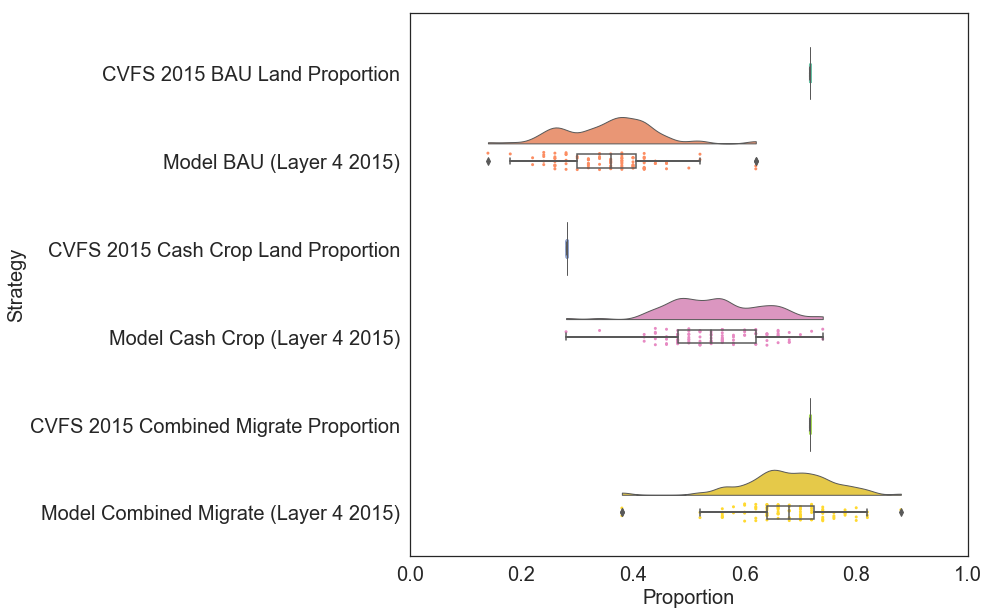

In [146]:
#Validation Plot Static - RainCloud Plots of strategy distributions vs. distribution of strategies in final CVFS year
import seaborn as sns
import pandas as pd
import ptitprince

bau_data = np.zeros(simulations)
diverse_data = np.zeros(simulations)
overseas_migrate_data = np.zeros(simulations)
local_migrate_data = np.zeros(simulations)
nepal_bau_data = np.zeros(simulations)
nepal_overseas_migrate_data = np.zeros(simulations)
nepal_local_migrate_data = np.zeros(simulations)
nepal_diverse_data = np.zeros(simulations)
combined_migrant_households = np.zeros((simulations, time))
combined_migrate = np.zeros(simulations)
nepal_combined_data = np.zeros(simulations)
strategies = [''] * simulations * 6

sim_bau_proportion = np.load('Layer4_BAUproportion.npy')
sim_diverse_proportion = np.load('Layer4_Diverseproportion.npy')
sim_overseas_migrate_proportion = np.load('Layer4_Overseasmigrateproportion.npy')
sim_local_migrate_proportion = np.load('Layer4_Localmigrateproportion.npy')
sim_household_size = np.load('Layer4_Householdsize.npy')


for a in range(simulations):
    for t in range(time):
        combined_migrant_households[a,t] = np.count_nonzero(sim_household_size[a,t,:] < 5) / households
        
    bau_data[a] = sim_bau_proportion[-1, -1, a,17]
    strategies[a] = 'CVFS 2015 BAU Land Proportion'
    nepal_bau_data[a] = (0.718)
    strategies[simulations+a] = 'Model BAU (Layer 4 2015)'
    diverse_data[a] = sim_diverse_proportion[-1, -1, a,17]
    strategies[2*simulations+a] = 'CVFS 2015 Cash Crop Land Proportion'
    nepal_diverse_data[a] = (0.282)
    strategies[3*simulations+a] = 'Model Cash Crop (Layer 4 2015)'
    combined_migrate[a] = combined_migrant_households[a,17]
    nepal_combined_data[a] = 0.718
    strategies[4*simulations+a] = "CVFS 2015 Combined Migrate Proportion"
    strategies[5*simulations+a] = "Model Combined Migrate (Layer 4 2015)"
    #overseas_migrate_data[a] = sim_overseas_migrate_proportion[-1, -1, a,17]
    #strategies[6*simulations+a] = 'CVFS 2015 Overseas Migrant Households (Est.)'
    #nepal_overseas_migrate_data[a] = (0.718*0.59)
    #strategies[7*simulations+a] = 'Model Overseas Migrate (Layer 4 2015)'
    #local_migrate_data[a] = sim_local_migrate_proportion[-1, -1, a,17]
    #strategies[8*simulations+a] = 'CVFS 2015 Local Migrant Households (Est.)'
    #nepal_local_migrate_data[a] = (0.718*0.41)
    #strategies[9*simulations+a] = 'Model Local Migrate (Layer 4 2015)'    

strategy_data = np.concatenate((nepal_bau_data, bau_data, nepal_diverse_data, diverse_data, nepal_combined_data, combined_migrate), axis=None)


strategy_df = pd.DataFrame({'Proportion': strategy_data, 'Strategy': strategies})

sns.set(style="white", font_scale=1.5)
dx = "Strategy"; dy = "Proportion"; ort="h"; pal="Set2"; sigma=0.2

ax=ptitprince.RainCloud(x=dx, y=dy, data=strategy_df, palette=pal, bw=sigma, width_viol=0.6, figsize= (10,10), orient=ort)

ax.set_xlim([0,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Proportion', fontsize=20)
plt.ylabel('Strategy', fontsize=20)
plt.show()

#plt.savefig('Layer4_Strategies_Validation.png', bbox_inches='tight')
#print('Layer4 Combined Migrate Year 9:', np.median(combined_migrate), file=open('ModelLayers.txt', 'a'))
print('Layer4 BAU Year 9:', np.median(bau_data), file=open('ModelLayers.txt', 'a'))
print('Layer4 Cash Crop Year 9:', np.median(diverse_data), file=open('ModelLayers.txt', 'a'))





In [21]:
#Plot of household strategy outcomes as a function of parameter being varied

#risk_steps = 10
#simulations = 100

#sim_bau_proportion = np.load('HouseholdSizeSens_BAUproportion.npy')
#sim_diverse_proportion = np.load('HouseholdSizeSens_Diverseproportion.npy')
#sim_migrate_proportion = np.load('HouseholdSizeSens_Migrateproportion.npy')

#sim_migrant_proportion = np.load('HouseholdSizeSens_migrants.npy')



avg_set_bau_proportion = np.zeros(risk_steps)
std_set_bau_proportion = np.zeros(risk_steps)
avg_set_bau_proportion_10pct = np.zeros(risk_steps)
avg_set_bau_proportion_90pct = np.zeros(risk_steps)

avg_set_diverse_proportion = np.zeros(risk_steps)
std_set_diverse_proportion = np.zeros(risk_steps)
avg_set_diverse_proportion_10pct = np.zeros(risk_steps)
avg_set_diverse_proportion_90pct = np.zeros(risk_steps)

avg_set_migrate_proportion = np.zeros(risk_steps)
std_set_migrate_proportion = np.zeros(risk_steps)
avg_set_migrate_proportion_10pct = np.zeros(risk_steps)
avg_set_migrate_proportion_90pct = np.zeros(risk_steps)

avg_set_migrant_proportion = np.zeros(risk_steps)
std_set_migrant_proportion = np.zeros(risk_steps)

sens_remittances_shared = np.zeros(risk_steps)
start_risk_parameter = 0
final_risk_parameter = 0.5
x = np.linspace(start_risk_parameter, final_risk_parameter, risk_steps)


for a in range(risk_steps):
    avg_set_bau_proportion[a] = sum(sim_bau_proportion[-1,a,:,-1]) / simulations
    std_set_bau_proportion[a] = np.std(sim_bau_proportion[-1,a,:,-1])    
    avg_set_bau_proportion_10pct[a] = np.percentile(sim_bau_proportion[-1,a,:,-1], 10.0)
    avg_set_bau_proportion_90pct[a] = np.percentile(sim_bau_proportion[-1,a,:,-1], 90.0)
    avg_set_diverse_proportion[a] = sum(sim_diverse_proportion[-1,a,:,-1]) / simulations
    std_set_diverse_proportion[a] = np.std(sim_diverse_proportion[-1,a,:,-1])    
    avg_set_diverse_proportion_10pct[a] = np.percentile(sim_diverse_proportion[-1,a,:,-1], 10.0)
    avg_set_diverse_proportion_90pct[a] = np.percentile(sim_diverse_proportion[-1,a,:,-1], 90.0)
    avg_set_migrate_proportion[a] = sum(sim_migrate_proportion[-1,a,:,-1]) / simulations
    std_set_migrate_proportion[a] = np.std(sim_migrate_proportion[-1,a,:,-1])    
    avg_set_migrate_proportion_10pct[a] = np.percentile(sim_migrate_proportion[-1,a,:,-1], 15.9)
    avg_set_migrate_proportion_90pct[a] = np.percentile(sim_migrate_proportion[-1,a,:,-1], 84.1)
    
    #avg_set_migrant_proportion[a] = np.average(sim_migrant_proportion[-1,a,:,-1])
    #std_set_migrant_proportion[a] = np.std(sim_migrant_proportion[-1,a,:,-1])
        
fig, ax1 = plt.subplots(figsize=(12,8))

ax1.plot(x, avg_set_bau_proportion, label='BAU', color='green')
#ax1.fill_between(x, avg_set_bau_proportion_10pct, avg_set_bau_proportion_90pct, color='lightgreen')
ax1.fill_between(x, (avg_set_bau_proportion - std_set_bau_proportion), (avg_set_bau_proportion + std_set_bau_proportion), color='lightgreen')

ax1.plot(x, avg_set_diverse_proportion, label='Diverse', color='purple')
#ax1.fill_between(x, avg_set_diverse_proportion_10pct, avg_set_diverse_proportion_90pct, color = 'lavender')
ax1.fill_between(x, (avg_set_diverse_proportion - std_set_diverse_proportion), (avg_set_diverse_proportion + std_set_diverse_proportion), color='lavender')

ax1.plot(x, avg_set_migrate_proportion, label='Migrate', color='blue')
#ax1.fill_between(x, avg_set_migrate_proportion_10pct, avg_set_migrate_proportion_90pct, color = 'lightblue')
ax1.fill_between(x, (avg_set_migrate_proportion - std_set_migrate_proportion), (avg_set_migrate_proportion + std_set_migrate_proportion), color='lightblue')


#ax1.plot(x, avg_set_migrant_proportion, label='Migrant Proportion', color='darkorange')
#ax1.fill_between(x, (avg_set_migrant_proportion - std_set_migrant_proportion), (avg_set_migrant_proportion + std_set_migrant_proportion), color='bisque')

ax1.set_ylabel('Proportion of Households', fontsize=20)
ax1.set_ylim([0,1])
ax1.set_xlabel('Household Discount Rate', fontsize=20)
#ax2=ax1.twinx()
#ax2.plot(x, avg_degree, label='Average Degree', color='red')
#ax2.set_ylabel('Average Household Degree of Connections')
ax1.set_xlim([0,0.5])

#lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.legend(fontsize=20, loc="upper left")
plt.xticks(size=20)
plt.yticks(size=20)

#plt.show()



plt.savefig('Discount_Sens_Strategies.png', bbox_inches='tight')

#print('Gamma Sens Risk Values:', x, file=open('Layer2_sensitivities_info.txt', 'a'))
#print('Gamma Sens BAU Households final time:', avg_set_bau_proportion, file=open('Layer2_sensitivities_info.txt', 'a'))
#print('Gamma Sens Diverse Households final time:', avg_set_diverse_proportion, file=open('Layer2_sensitivities_info.txt', 'a'))
#print('Gamma Sens Migrate Households final time:', avg_set_migrate_proportion, file=open('Layer2_sensitivities_info.txt', 'a'))



In [ ]:
#Sensitivity of Social Utility to Parameter being varied

avg_final_utility = np.zeros(risk_steps)
avg_final_utility_16pct = np.zeros(risk_steps)
avg_final_utility_84pct = np.zeros(risk_steps)

for a in range(risk_steps):
    avg_final_utility[a] = np.average(sim_cumulative_utility[-1,a,:,-1]) / 1000000
    avg_final_utility_16pct[a] = np.percentile(sim_cumulative_utility[-1,a,:,-1], 15.9) / 1000000
    avg_final_utility_84pct[a] = np.percentile(sim_cumulative_utility[-1,a,:,-1], 84.1) / 1000000
    
x = sim_delta_parameter

fig, ax1 = plt.subplots()
ax1.plot(x, avg_final_utility, color='Orange')
ax1.fill_between(x, avg_final_utility_16pct, avg_final_utility_84pct, color='navajowhite')

ax1.set_ylabel('Household Size')
ax1.set_xlabel('Proportion of Remittances Shared')

plt.show()


#print('Remittance Beta Values:', x, file=open('RiskMechanisms_sensitivities.txt', 'a'))
#print('Remittance Beta Sens Social Utility:', avg_final_utility, file=open('RiskMechanisms_sensitivities.txt', 'a'))

In [32]:
#Graph of migrant proportion

layer3 = np.load('Layer4T0_migrants.npy')
layer4 = np.load('Layer4TempRiskSens_migrants.npy')

temp_steps = 11
risk_steps = 11
start_temp_parameter = 0
final_temp_parameter = 5

start_risk_parameter = 0
final_risk_parameter = 2

migrant_gap = np.zeros((temp_steps, risk_steps))
y = np.zeros(temp_steps)
x = np.zeros(risk_steps)
ylabels=[]
xlabels=[]




for a in range(temp_steps):
    y[a] = a / (temp_steps-1) * (final_temp_parameter - start_temp_parameter) + start_temp_parameter
    if a % 2 == 0:
        ylabels.append(str('%.1f'%y[a]))
    for b in range(risk_steps):
        x[b] = b / (risk_steps-1) * (final_risk_parameter - start_risk_parameter) + start_risk_parameter
        
        before_migrants = np.average(layer4[0,b,:,-1])
        after_migrants = np.average(layer4[a,b,:,-1])
        migrant_gap[a,b] = (after_migrants)
        
for c in range(risk_steps):
    xlabels.append(str('%.1f'%x[c]))

        
z = migrant_gap
[X,Y] = np.meshgrid(x, y)
level_labels=[]
levels = np.linspace(0.0, 0.7, 15)
for i in range(len(levels)):
    if i % 2 == 0:
        level_labels.append(levels[i]) 


fig, ax = plt.subplots(figsize=[30,8])
contour_map = ax.contourf(X, Y, z, levels, cmap=plt.cm.RdBu)
cbar = fig.colorbar(contour_map, ticks=level_labels)
cbar.ax.set_ylabel('Proportion of Community That Migrates', size=20)
cbar.ax.tick_params(labelsize=20)

ax.set_xlabel('Risk Weighting', size=20)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, size=20)
ax.set_ylim([0,5])
ax.set_ylabel('Temperature Change ($^0C$)', size=20)
ax.set_yticklabels(ylabels, size=20)

plt.text(0.25, 4.25, 'A', size=32)
plt.text(0.5, 1.5, 'B', size=32)
plt.text(1.25, 3.0, 'C', size=32)

#plt.show()



#np.set_printoptions(threshold=100)
plt.savefig('MigrantProportionRiskTempSens.eps', bbox_inches='tight')

#print('Temp Values(y):', y, file=open('SocialUtilityGapAnalysis_RovingPlanner.txt', 'a'))
#print('Risk Weighting Values(x):', x, file=open('SocialUtilityGapAnalysis_RovingPlanner.txt', 'a'))
#print('Roving Planner Absolute Utility Gap(y,x):', utility_gap_avg, file=open('SocialUtilityGapAnalysis_RovingPlanner.txt', 'a'))
